In [1]:
# import libraries
import numpy as np
import requests, gzip, os, hashlib
%matplotlib inline
import seaborn as sns
import sklearn.linear_model as skl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree, export_text)
from sklearn.metrics import (accuracy_score , log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF,
                              GradientBoostingRegressor as GBR)
from ISLP.bart import BART
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import mode
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import KFold
import statsmodels.api as sm
import time
import itertools
from sklearn.cross_decomposition import PLSRegression
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from matplotlib.pyplot import subplots
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

----
### **Data Cleaning**

In [2]:
# data without dropping every column
df_all = pd.read_csv('Most-Recent-Cohorts-Institution.csv')
df_all.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP8_NOPELL_FIRSTTIME,OMENRUP_NOPELL_FIRSTTIME,OMENRYP_NOPELL_NOTFIRSTTIME,OMENRAP_NOPELL_NOTFIRSTTIME,OMAWDP8_NOPELL_NOTFIRSTTIME,OMENRUP_NOPELL_NOTFIRSTTIME,OMACHT8_NOPELL_ALL,OMACHT8_NOPELL_FIRSTTIME,OMACHT8_NOPELL_NOTFIRSTTIME,ADDR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,0.3187,0.2709,0.0128,0.2949,0.4744,0.2179,329.0,251.0,78.0,4900 Meridian Street
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,0.6937,0.0660,0.0111,0.2636,0.5136,0.2117,2358.0,1182.0,1176.0,Administration Bldg Suite 1070
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,0.0000,0.5000,0.0000,0.3333,0.4583,0.2083,26.0,2.0,24.0,1200 Taylor Rd
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,0.6471,0.0941,0.0082,0.2647,0.5948,0.1324,1122.0,510.0,612.0,301 Sparkman Dr
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,0.4381,0.2167,0.0000,0.1444,0.3667,0.4889,510.0,420.0,90.0,915 S Jackson Street


In [3]:
df_selected = df_all.dropna(thresh = 4000, axis=1)

# count the number of 'PrivacySuppressed' for each column
more_privacy_suppressed = df_selected.columns[df_selected[df_selected == 'PrivacySuppressed'].count() != 0]

# drop columns with 'PrivacySuppressed'
df_selected = df_selected.drop(more_privacy_suppressed, axis = 1)

df_selected.shape

(6543, 398)

In [4]:
df_selected.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6543 entries, 0 to 6542
Data columns (total 398 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    UNITID                      6543 non-null   int64  
 1    OPEID                       6523 non-null   float64
 2    OPEID6                      6523 non-null   float64
 3    INSTNM                      6543 non-null   object 
 4    CITY                        6543 non-null   object 
 5    STABBR                      6543 non-null   object 
 6    ZIP                         6543 non-null   object 
 7    ACCREDAGENCY                6304 non-null   object 
 8    INSTURL                     6526 non-null   object 
 9    NPCURL                      6003 non-null   object 
 10   SCH_DEG                     6177 non-null   float64
 11   HCM2                        6543 non-null   int64  
 12   MAIN                        6543 non-null   int64  
 13   NUMBRANCH       

In [5]:
# only look at the main campus as other campuses have the same information
df_selected_main = df_selected[df_selected['MAIN'] == 1]
df_selected_main.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,IRPS_WOMEN,IRPS_MEN,MD_EARN_WNE_1YR,GT_THRESHOLD_1YR,COUNT_NWNE_4YR,COUNT_WNE_4YR,MD_EARN_WNE_4YR,GT_THRESHOLD_4YR,CONTROL_PEPS,ADDR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,0.5024,0.4976,30999.0,287.0,35.0,505.0,46562.0,380.0,Public,4900 Meridian Street
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,0.4433,0.5567,45270.0,1950.0,138.0,2355.0,52404.0,1892.0,Public,Administration Bldg Suite 1070
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,0.1471,0.8529,NaN,NaN,5.0,35.0,45765.0,21.0,Private Nonprofit,1200 Taylor Rd
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,0.4644,0.5356,57386.0,976.0,88.0,1129.0,67695.0,991.0,Public,301 Sparkman Dr
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,0.4796,0.5204,27282.0,268.0,36.0,625.0,37551.0,387.0,Public,915 S Jackson Street


In [6]:
# filter to only look at schools that are operating
df_selected_main = df_selected_main[(df_selected_main['CURROPER'] == 1)]

In [7]:
# school info
school_info = ['UNITID', 'INSTNM', 'STABBR', 'CONTROL', 'HIGHDEG', 'PCTFLOAN', 'STUFACR', 'TUITFTE', 'INEXPFTE', 'PCTPELL', 'PFTFTUG1_EF']

# major
Major_pct = df_selected.columns[df_selected.columns.str.startswith('PCIP')]

# students' seeking degree's demographics
UGDS_demo = df_selected.columns[df_selected.columns.str.startswith('UGDS')]
student_demo = ['PPTUG_EF','UG25ABV']

# default rate
CDR = ['CDR2', 'CDR3']

In [8]:
WNE = df_selected_main.columns[df_selected_main.columns.str.contains('WNE_')]
WNE.shape

(59,)

In [9]:
# get columns that contain WNE and P6/8/10 from df_selected_main
WNE_P6 = df_selected_main.columns[df_selected_main.columns.str.contains('WNE_') & df_selected_main.columns.str.contains('P6')]
# WNE_P6.shape #(17,)

WNE_P8 = df_selected_main.columns[df_selected_main.columns.str.contains('WNE_') & df_selected_main.columns.str.contains('P8')]
# WNE_P8.shape #(17,)

WNE_P10 = df_selected_main.columns[df_selected_main.columns.str.contains('WNE_') & df_selected_main.columns.str.contains('P10')]
# WNE_P10.shape #(17,)

In [10]:
# columns in WNE that are not in WNE_P6 and P8 and P10
WNE_other = WNE[~WNE.isin(WNE_P6) & ~WNE.isin(WNE_P8) & ~WNE.isin(WNE_P10)]
WNE_other

Index(['COUNT_NWNE_3YR', 'COUNT_WNE_3YR', 'COUNT_NWNE_1YR', 'COUNT_WNE_1YR',
       'MD_EARN_WNE_1YR', 'COUNT_NWNE_4YR', 'COUNT_WNE_4YR',
       'MD_EARN_WNE_4YR'],
      dtype='object')

In [11]:
# get the column name for WNE_P10 except _P10 at the end
WNE_P10_2 = WNE_P10.str.replace('_P10', '')
WNE_P8_2 = WNE_P8.str.replace('_P8', '')
WNE_P6_2 = WNE_P6.str.replace('_P6', '')

# check if the column names are the same regardless of order
print(WNE_P10_2.sort_values().equals(WNE_P8_2.sort_values()))
print(WNE_P10_2.sort_values().equals(WNE_P6_2.sort_values()))

True
True


In [12]:
df_selected_main[WNE_P6].describe()

,COUNT_NWNE_P6,COUNT_WNE_P6,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,COUNT_WNE_INC1_P6,COUNT_WNE_INC2_P6,COUNT_WNE_INDEP0_P6,COUNT_WNE_INDEP1_P6,COUNT_WNE_MALE0_P6,COUNT_WNE_MALE1_P6,MD_EARN_WNE_INC1_P6,MD_EARN_WNE_INC2_P6,MD_EARN_WNE_INDEP1_P6,MD_EARN_WNE_INDEP0_P6,MD_EARN_WNE_MALE0_P6,MD_EARN_WNE_MALE1_P6
count,4511.000000,4154.000000,4154.000000,4065.000000,4130.000000,3943.000000,3545.000000,3772.000000,3794.000000,3959.000000,3352.000000,3943.00000,3545.000000,3794.000000,3772.000000,3959.000000,3352.000000
mean,314.600089,1359.108089,35873.958835,21201.201968,52439.522276,822.358864,420.807898,834.460764,655.873221,813.673150,720.728222,33442.82805,40188.996333,36222.068793,35895.640509,33707.694620,41420.951671
std,837.421947,3104.101058,13637.966082,10379.016856,17434.007937,2209.068813,783.238226,1338.575609,2408.086214,1992.154528,1333.342760,12725.37557,12217.146366,14181.851695,12901.172423,12957.671479,13957.776864
min,0.000000,16.000000,9040.000000,2890.000000,16594.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9922.00000,10517.000000,7959.000000,9220.000000,9187.000000,7656.000000
25%,27.000000,154.000000,26792.250000,14071.000000,40927.500000,94.000000,66.000000,99.000000,74.000000,113.000000,116.750000,25298.50000,33447.000000,26545.250000,27850.000000,24957.500000,33591.250000
50%,86.000000,506.000000,33817.500000,18931.000000,49722.000000,260.000000,190.000000,364.000000,205.000000,316.000000,314.000000,31517.00000,38422.000000,33716.500000,33750.000000,31197.000000,39407.500000
75%,310.000000,1473.250000,42895.250000,27108.000000,61128.000000,888.500000,467.000000,932.250000,652.750000,883.000000,802.250000,39335.00000,45466.000000,43931.000000,41853.250000,40204.500000,47271.250000
max,32238.000000,122091.000000,147347.000000,100990.000000,192627.000000,89944.000000,25847.000000,19682.000000,110731.000000,82647.000000,39444.000000,166707.00000,149629.000000,132559.000000,148193.000000,130322.000000,146293.000000


In [13]:
# count the number of NULL values for each column
df_selected_main[WNE_P6].isnull().sum().sort_values(ascending=False)

MD_EARN_WNE_MALE1_P6     1722
COUNT_WNE_MALE1_P6       1722
MD_EARN_WNE_INC2_P6      1529
COUNT_WNE_INC2_P6        1529
COUNT_WNE_INDEP0_P6      1302
MD_EARN_WNE_INDEP0_P6    1302
MD_EARN_WNE_INDEP1_P6    1280
COUNT_WNE_INDEP1_P6      1280
COUNT_WNE_INC1_P6        1131
MD_EARN_WNE_INC1_P6      1131
COUNT_WNE_MALE0_P6       1115
MD_EARN_WNE_MALE0_P6     1115
PCT25_EARN_WNE_P6        1009
PCT75_EARN_WNE_P6         944
COUNT_WNE_P6              920
MD_EARN_WNE_P6            920
COUNT_NWNE_P6             563
dtype: int64

In [14]:
df_selected_main[WNE_P8].isnull().sum().sort_values(ascending=False)

MD_EARN_WNE_MALE1_P8     1726
COUNT_WNE_MALE1_P8       1726
COUNT_WNE_INC2_P8        1558
MD_EARN_WNE_INC2_P8      1558
COUNT_WNE_INDEP0_P8      1378
MD_EARN_WNE_INDEP0_P8    1378
COUNT_WNE_INDEP1_P8      1339
MD_EARN_WNE_INDEP1_P8    1339
COUNT_WNE_MALE0_P8       1197
MD_EARN_WNE_MALE0_P8     1197
COUNT_WNE_INC1_P8        1145
MD_EARN_WNE_INC1_P8      1145
PCT25_EARN_WNE_P8        1084
PCT75_EARN_WNE_P8        1023
COUNT_WNE_P8             1001
MD_EARN_WNE_P8           1001
COUNT_NWNE_P8             619
dtype: int64

In [15]:
df_selected_main[WNE_P10].isnull().sum().sort_values(ascending=False)

MD_EARN_WNE_MALE1_P10     1909
COUNT_WNE_MALE1_P10       1909
COUNT_WNE_INC2_P10        1776
MD_EARN_WNE_INC2_P10      1776
MD_EARN_WNE_INDEP1_P10    1589
COUNT_WNE_INDEP1_P10      1589
COUNT_WNE_INDEP0_P10      1587
MD_EARN_WNE_INDEP0_P10    1587
COUNT_WNE_MALE0_P10       1383
MD_EARN_WNE_MALE0_P10     1383
COUNT_WNE_INC1_P10        1366
MD_EARN_WNE_INC1_P10      1366
PCT25_EARN_WNE_P10        1282
PCT75_EARN_WNE_P10        1217
COUNT_WNE_P10             1194
MD_EARN_WNE_P10           1194
COUNT_NWNE_P10             781
dtype: int64

In [16]:
df_selected_main[WNE_other].isnull().sum().sort_values(ascending=False)

COUNT_WNE_4YR      810
MD_EARN_WNE_4YR    810
COUNT_WNE_3YR      778
COUNT_WNE_1YR      715
MD_EARN_WNE_1YR    715
COUNT_NWNE_3YR     371
COUNT_NWNE_4YR     358
COUNT_NWNE_1YR     254
dtype: int64

In [17]:
# check the NULL rows for each group
df_selected_main[df_selected_main[WNE_P6].isna().all(axis=1)].shape # (88, 398)

df_selected_main[df_selected_main[WNE_P8].isna().all(axis=1)].shape # (143, 398)

df_selected_main[df_selected_main[WNE_P10].isna().all(axis=1)].shape # (317, 398)

df_selected_main[df_selected_main[WNE_other].isna().all(axis=1)].shape # (180, 398)

(169, 398)

In [18]:
# since there are much more NULL in P10 and it's too long after entry, we will use P6 and P8
WNE_P6_8_other = WNE_P6.append(WNE_P8).append(WNE_other)
df_selected_main[WNE_P6_8_other].isnull().sum().sort_values(ascending=False)

COUNT_WNE_MALE1_P8       1726
MD_EARN_WNE_MALE1_P8     1726
COUNT_WNE_MALE1_P6       1722
MD_EARN_WNE_MALE1_P6     1722
MD_EARN_WNE_INC2_P8      1558
COUNT_WNE_INC2_P8        1558
MD_EARN_WNE_INC2_P6      1529
COUNT_WNE_INC2_P6        1529
COUNT_WNE_INDEP0_P8      1378
MD_EARN_WNE_INDEP0_P8    1378
MD_EARN_WNE_INDEP1_P8    1339
COUNT_WNE_INDEP1_P8      1339
MD_EARN_WNE_INDEP0_P6    1302
COUNT_WNE_INDEP0_P6      1302
COUNT_WNE_INDEP1_P6      1280
MD_EARN_WNE_INDEP1_P6    1280
MD_EARN_WNE_MALE0_P8     1197
COUNT_WNE_MALE0_P8       1197
COUNT_WNE_INC1_P8        1145
MD_EARN_WNE_INC1_P8      1145
MD_EARN_WNE_INC1_P6      1131
COUNT_WNE_INC1_P6        1131
MD_EARN_WNE_MALE0_P6     1115
COUNT_WNE_MALE0_P6       1115
PCT25_EARN_WNE_P8        1084
PCT75_EARN_WNE_P8        1023
PCT25_EARN_WNE_P6        1009
COUNT_WNE_P8             1001
MD_EARN_WNE_P8           1001
PCT75_EARN_WNE_P6         944
COUNT_WNE_P6              920
MD_EARN_WNE_P6            920
COUNT_WNE_4YR             810
MD_EARN_WN

In [19]:
# only select the columns we need
df_selected2 = df_selected_main[school_info + Major_pct.tolist() + UGDS_demo.tolist() + student_demo + CDR + WNE_P6_8_other.tolist()]
df_selected2.head()

,UNITID,INSTNM,STABBR,CONTROL,HIGHDEG,PCTFLOAN,STUFACR,TUITFTE,INEXPFTE,PCTPELL,...,COUNT_WNE_MALE1_P8,MD_EARN_WNE_MALE1_P8,COUNT_NWNE_3YR,COUNT_WNE_3YR,COUNT_NWNE_1YR,COUNT_WNE_1YR,MD_EARN_WNE_1YR,COUNT_NWNE_4YR,COUNT_WNE_4YR,MD_EARN_WNE_4YR
0,100654,Alabama A & M University,AL,1,4,0.6552,18.0,9243.0,7699.0,0.6853,...,898.0,36294.0,16.0,495.0,27.0,583.0,30999.0,35.0,505.0,46562.0
1,100663,University of Alabama at Birmingham,AL,1,4,0.4401,19.0,11678.0,14264.0,0.3253,...,1355.0,52288.0,111.0,2294.0,150.0,2786.0,45270.0,138.0,2355.0,52404.0
2,100690,Amridge University,AL,2,4,0.8423,13.0,14093.0,4381.0,0.7852,...,79.0,54158.0,6.0,30.0,NaN,NaN,NaN,5.0,35.0,45765.0
3,100706,University of Alabama in Huntsville,AL,1,4,0.3578,19.0,8246.0,8156.0,0.2377,...,875.0,61385.0,52.0,1124.0,54.0,1216.0,57386.0,88.0,1129.0,67695.0
4,100724,Alabama State University,AL,1,4,0.7637,13.0,8535.0,9459.0,0.7205,...,993.0,33278.0,18.0,579.0,27.0,689.0,27282.0,36.0,625.0,37551.0


In [20]:
df_selected2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5074 entries, 0 to 6037
Data columns (total 107 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    UNITID                 5074 non-null   int64  
 1    INSTNM                 5074 non-null   object 
 2    STABBR                 5074 non-null   object 
 3    CONTROL                5074 non-null   int64  
 4    HIGHDEG                5074 non-null   int64  
 5    PCTFLOAN               4808 non-null   float64
 6    STUFACR                4821 non-null   float64
 7    TUITFTE                5067 non-null   float64
 8    INEXPFTE               5067 non-null   float64
 9    PCTPELL                4808 non-null   float64
 10   PFTFTUG1_EF            4602 non-null   float64
 11   PCIP01                 4824 non-null   float64
 12   PCIP03                 4824 non-null   float64
 13   PCIP04                 4824 non-null   float64
 14   PCIP05                 4824 non-null  

In [21]:
# count the number of NaN for each column
pd.set_option('display.max_rows', None)

df_selected2.isna().sum().sort_values(ascending=False)

MD_EARN_WNE_MALE1_P8     1726
COUNT_WNE_MALE1_P8       1726
COUNT_WNE_MALE1_P6       1722
MD_EARN_WNE_MALE1_P6     1722
MD_EARN_WNE_INC2_P8      1558
COUNT_WNE_INC2_P8        1558
MD_EARN_WNE_INC2_P6      1529
COUNT_WNE_INC2_P6        1529
MD_EARN_WNE_INDEP0_P8    1378
COUNT_WNE_INDEP0_P8      1378
MD_EARN_WNE_INDEP1_P8    1339
COUNT_WNE_INDEP1_P8      1339
MD_EARN_WNE_INDEP0_P6    1302
COUNT_WNE_INDEP0_P6      1302
MD_EARN_WNE_INDEP1_P6    1280
COUNT_WNE_INDEP1_P6      1280
MD_EARN_WNE_MALE0_P8     1197
COUNT_WNE_MALE0_P8       1197
COUNT_WNE_INC1_P8        1145
MD_EARN_WNE_INC1_P8      1145
COUNT_WNE_INC1_P6        1131
MD_EARN_WNE_INC1_P6      1131
COUNT_WNE_MALE0_P6       1115
MD_EARN_WNE_MALE0_P6     1115
PCT25_EARN_WNE_P8        1084
PCT75_EARN_WNE_P8        1023
PCT25_EARN_WNE_P6        1009
MD_EARN_WNE_P8           1001
COUNT_WNE_P8             1001
PCT75_EARN_WNE_P6         944
COUNT_WNE_P6              920
MD_EARN_WNE_P6            920
MD_EARN_WNE_4YR           810
COUNT_WNE_

In [22]:
df_selected2.shape

(5074, 107)

In [23]:
null_columns = df_selected2.columns[df_selected2.isna().sum() != 0]

In [24]:
pd.set_option('display.max_columns', None)

df_selected2[null_columns].describe()

,PCTFLOAN,STUFACR,TUITFTE,INEXPFTE,PCTPELL,PFTFTUG1_EF,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UGDS_MEN,UGDS_WOMEN,PPTUG_EF,UG25ABV,CDR2,CDR3,COUNT_NWNE_P6,COUNT_WNE_P6,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,COUNT_WNE_INC1_P6,COUNT_WNE_INC2_P6,COUNT_WNE_INDEP0_P6,COUNT_WNE_INDEP1_P6,COUNT_WNE_MALE0_P6,COUNT_WNE_MALE1_P6,MD_EARN_WNE_INC1_P6,MD_EARN_WNE_INC2_P6,MD_EARN_WNE_INDEP1_P6,MD_EARN_WNE_INDEP0_P6,MD_EARN_WNE_MALE0_P6,MD_EARN_WNE_MALE1_P6,COUNT_NWNE_P8,COUNT_WNE_P8,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,COUNT_WNE_INC1_P8,MD_EARN_WNE_INC1_P8,COUNT_WNE_INC2_P8,MD_EARN_WNE_INC2_P8,COUNT_WNE_INDEP1_P8,MD_EARN_WNE_INDEP1_P8,COUNT_WNE_INDEP0_P8,MD_EARN_WNE_INDEP0_P8,COUNT_WNE_MALE0_P8,MD_EARN_WNE_MALE0_P8,COUNT_WNE_MALE1_P8,MD_EARN_WNE_MALE1_P8,COUNT_NWNE_3YR,COUNT_WNE_3YR,COUNT_NWNE_1YR,COUNT_WNE_1YR,MD_EARN_WNE_1YR,COUNT_NWNE_4YR,COUNT_WNE_4YR,MD_EARN_WNE_4YR
count,4808.000000,4821.000000,5067.000000,5067.000000,4808.000000,4602.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4824.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4826.000000,4809.000000,4739.000000,4267.000000,4329.000000,4511.000000,4154.000000,4154.000000,4065.000000,4130.000000,3943.000000,3545.000000,3772.000000,3794.000000,3959.000000,3352.000000,3943.00000,3545.000000,3794.000000,3772.000000,3959.000000,3352.000000,4455.000000,4073.000000,4073.000000,3990.000000,4051.000000,3929.000000,3929.000000,3516.000000,3516.000000,3735.000000,3735.000000,3696.000000,3696.000000,3877.000000,3877.000000,3348.000000,3348.000000,4703.000000,4296.000000,4820.000000,4359.000000,4359.000000,4716.000000,4264.000000,4264.000000
mean,0.396581,14.640946,10706.665285,9296.034735,0.412853,0.679319,0.009204,0.003991,0.001859,0.001560,0.013284,0.004608,0.025756,0.192462,0.026385,0.013272,0.014797,0.002804,0.006672,0.003380,0.006930,0.075359,0.000065,0.022847,0.004016,0.000475,0.012860,0.012067,0.022046,0.021549,0.005356,0.000863,0.023177,0.021566,0.008344,0.020505,0.010698,0.029308,0.014776,0.008492,0.032222,0.228373,0.089640,0.004286,2818.775176,0.491089,0.170858,0.185723,0.040370,0.014673,0.004555,0.034177,0.022367,0.034325,0.364555,0.633580,0.244404,0.346989,0.081644,0.030443,314.600089,1359.108089,35873.958835,21201.201968,52439.522276,822.358864,420.807898,834.460764,655.873221,813.673150,720.728222,33442.82805,40188.996333,36222.068793,35895.640509,33707.694620,41420.951671,359.899663,1521.382274,38962.500123,23103.671930,57335.373241,891.253245,36127.345890,490.239477,43414.228100,758.674699,38526.221687,907.469156,39359.473755,918.762445,36418.534950,784.447133,45661.290621,48.022964,691.540968,43.386307,680.757284,34310.464327,56.375106,727.218340,40941.584897
std,0.275122,6.608047,9210.027012,14012.111542,0.204350,0.271080,0.057746,0.018075,0.028116,0.010608,0.041526,0.042950,0.067262,0.379599,0.068929,0.058288,0.052750,0.010034,0.027695,0.033071,0.020918,0.156714,0.001139,0.047358,0.010122,0.010334,0.045037,0.040558,0.138324,0.128812,0.017875,0.008375,0.050121,0.052493,0.028254,0.048847,0.054080,0.113951,0.064574,0.065924,0.120778,0.315396,0.126655,0.010110,6259.556457,0.279479,0.210904,0.219875,0.078472,0.079566,0.033680,0.038218,0.061529,0.07

In [25]:
# check if all columns starting with PCIP have the same rows with missing values
df_selected2[df_selected2['PCIP01'].isna() & df_selected2['PCIP03'].isna() & df_selected2['PCIP04'].isna() & 
             df_selected2['PCIP05'].isna() & df_selected2['PCIP09'].isna() & df_selected2['PCIP10'].isna() & 
             df_selected2['PCIP11'].isna() & df_selected2['PCIP12'].isna() & df_selected2['PCIP13'].isna() & 
             df_selected2['PCIP14'].isna() & df_selected2['PCIP15'].isna() & df_selected2['PCIP16'].isna() & 
             df_selected2['PCIP19'].isna() & df_selected2['PCIP22'].isna() & df_selected2['PCIP23'].isna() & 
             df_selected2['PCIP24'].isna() & df_selected2['PCIP25'].isna() & df_selected2['PCIP26'].isna() & 
             df_selected2['PCIP27'].isna() & df_selected2['PCIP29'].isna() & df_selected2['PCIP30'].isna() & 
             df_selected2['PCIP31'].isna() & df_selected2['PCIP38'].isna() & df_selected2['PCIP39'].isna() & 
             df_selected2['PCIP40'].isna() & df_selected2['PCIP41'].isna() & df_selected2['PCIP42'].isna() & 
             df_selected2['PCIP43'].isna() & df_selected2['PCIP44'].isna() & df_selected2['PCIP45'].isna() & 
             df_selected2['PCIP46'].isna() & df_selected2['PCIP47'].isna() & df_selected2['PCIP48'].isna() & 
             df_selected2['PCIP49'].isna() & df_selected2['PCIP50'].isna() & df_selected2['PCIP51'].isna() & 
             df_selected2['PCIP52'].isna() & df_selected2['PCIP54'].isna()].shape #(256, 108)
# they are missing for the same observations

# drop all these observations
df_selected2[df_selected2['PCIP01'].isna() & df_selected2['PCIP03'].isna() & df_selected2['PCIP04'].isna() & 
             df_selected2['PCIP05'].isna() & df_selected2['PCIP09'].isna() & df_selected2['PCIP10'].isna() & 
             df_selected2['PCIP11'].isna() & df_selected2['PCIP12'].isna() & df_selected2['PCIP13'].isna() & 
             df_selected2['PCIP14'].isna() & df_selected2['PCIP15'].isna() & df_selected2['PCIP16'].isna() & 
             df_selected2['PCIP19'].isna() & df_selected2['PCIP22'].isna() & df_selected2['PCIP23'].isna() & 
             df_selected2['PCIP24'].isna() & df_selected2['PCIP25'].isna() & df_selected2['PCIP26'].isna() & 
             df_selected2['PCIP27'].isna() & df_selected2['PCIP29'].isna() & df_selected2['PCIP30'].isna() & 
             df_selected2['PCIP31'].isna() & df_selected2['PCIP38'].isna() & df_selected2['PCIP39'].isna() & 
             df_selected2['PCIP40'].isna() & df_selected2['PCIP41'].isna() & df_selected2['PCIP42'].isna() & 
             df_selected2['PCIP43'].isna() & df_selected2['PCIP44'].isna() & df_selected2['PCIP45'].isna() & 
             df_selected2['PCIP46'].isna() & df_selected2['PCIP47'].isna() & df_selected2['PCIP48'].isna() & 
             df_selected2['PCIP49'].isna() & df_selected2['PCIP50'].isna() & df_selected2['PCIP51'].isna() & 
             df_selected2['PCIP52'].isna() & df_selected2['PCIP54'].isna()].head()
# observations that are missing these major information are likely to be missing other information as well
# drop these observations
df_selected3 = df_selected2.dropna(subset = Major_pct.tolist())
df_selected3.shape # (4942, 108)

(4824, 107)

In [26]:
# count the number of NaN for each column again
pd.set_option('display.max_rows', None)
df_selected3.isna().sum().sort_values(ascending=False)

COUNT_WNE_MALE1_P8       1478
MD_EARN_WNE_MALE1_P8     1478
MD_EARN_WNE_MALE1_P6     1472
COUNT_WNE_MALE1_P6       1472
COUNT_WNE_INC2_P8        1310
MD_EARN_WNE_INC2_P8      1310
COUNT_WNE_INC2_P6        1280
MD_EARN_WNE_INC2_P6      1280
MD_EARN_WNE_INDEP0_P8    1129
COUNT_WNE_INDEP0_P8      1129
COUNT_WNE_INDEP1_P8      1095
MD_EARN_WNE_INDEP1_P8    1095
MD_EARN_WNE_INDEP0_P6    1053
COUNT_WNE_INDEP0_P6      1053
MD_EARN_WNE_INDEP1_P6    1034
COUNT_WNE_INDEP1_P6      1034
MD_EARN_WNE_MALE0_P8      950
COUNT_WNE_MALE0_P8        950
MD_EARN_WNE_INC1_P8       899
COUNT_WNE_INC1_P8         899
COUNT_WNE_INC1_P6         884
MD_EARN_WNE_INC1_P6       884
COUNT_WNE_MALE0_P6        868
MD_EARN_WNE_MALE0_P6      868
PCT25_EARN_WNE_P8         840
PCT75_EARN_WNE_P8         779
CDR2                      764
PCT25_EARN_WNE_P6         762
COUNT_WNE_P8              757
MD_EARN_WNE_P8            757
CDR3                      717
PCT75_EARN_WNE_P6         698
MD_EARN_WNE_P6            675
COUNT_WNE_

In [27]:
# check if columns starting with UGDS have the same rows with missing values
df_selected3[df_selected3['UGDS'].isna() & df_selected3['UGDS_WHITE'].isna() & df_selected3['UGDS_BLACK'].isna() & 
             df_selected3['UGDS_HISP'].isna() & df_selected3['UGDS_ASIAN'].isna() & df_selected3['UGDS_AIAN'].isna() & 
             df_selected3['UGDS_NHPI'].isna() & df_selected3['UGDS_2MOR'].isna() & df_selected3['UGDS_NRA'].isna() & 
             df_selected3['UGDS_UNKN'].isna()].shape #(3, 108)
# they are missing for the same observations

# drop all these observations
df_selected4 = df_selected3.dropna(subset = UGDS_demo.tolist())

In [28]:
null_columns2 = df_selected4.columns[df_selected4.isna().sum() != 0]
df_selected4[null_columns2].describe()

,PCTFLOAN,STUFACR,TUITFTE,INEXPFTE,PCTPELL,PFTFTUG1_EF,PPTUG_EF,UG25ABV,CDR2,CDR3,COUNT_NWNE_P6,COUNT_WNE_P6,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,COUNT_WNE_INC1_P6,COUNT_WNE_INC2_P6,COUNT_WNE_INDEP0_P6,COUNT_WNE_INDEP1_P6,COUNT_WNE_MALE0_P6,COUNT_WNE_MALE1_P6,MD_EARN_WNE_INC1_P6,MD_EARN_WNE_INC2_P6,MD_EARN_WNE_INDEP1_P6,MD_EARN_WNE_INDEP0_P6,MD_EARN_WNE_MALE0_P6,MD_EARN_WNE_MALE1_P6,COUNT_NWNE_P8,COUNT_WNE_P8,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,COUNT_WNE_INC1_P8,MD_EARN_WNE_INC1_P8,COUNT_WNE_INC2_P8,MD_EARN_WNE_INC2_P8,COUNT_WNE_INDEP1_P8,MD_EARN_WNE_INDEP1_P8,COUNT_WNE_INDEP0_P8,MD_EARN_WNE_INDEP0_P8,COUNT_WNE_MALE0_P8,MD_EARN_WNE_MALE0_P8,COUNT_WNE_MALE1_P8,MD_EARN_WNE_MALE1_P8,COUNT_NWNE_3YR,COUNT_WNE_3YR,COUNT_NWNE_1YR,COUNT_WNE_1YR,MD_EARN_WNE_1YR,COUNT_NWNE_4YR,COUNT_WNE_4YR,MD_EARN_WNE_4YR
count,4807.000000,4816.000000,4819.000000,4819.000000,4807.000000,4602.000000,4809.000000,4735.000000,4057.000000,4104.000000,4424.000000,4148.000000,4148.000000,4061.000000,4125.000000,3939.000000,3543.000000,3770.000000,3789.000000,3955.000000,3351.000000,3939.000000,3543.000000,3789.000000,3770.000000,3955.000000,3351.000000,4322.000000,4066.000000,4066.000000,3983.000000,4044.000000,3924.000000,3924.000000,3513.000000,3513.00000,3728.000000,3728.000000,3694.000000,3694.000000,3873.000000,3873.000000,3345.000000,3345.000000,4514.000000,4247.000000,4623.000000,4295.000000,4295.000000,4526.000000,4220.000000,4220.000000
mean,0.396572,14.640573,10276.902054,8597.178045,0.412858,0.679319,0.244404,0.346580,0.084564,0.031268,320.724005,1360.882112,35862.934185,21188.973159,52418.942545,823.074384,420.999718,834.817507,656.621008,814.333249,720.919725,33438.505458,40191.599492,36205.700713,35898.105570,33690.630341,41419.520740,370.876909,1523.772504,38936.629120,23078.253327,57302.939911,892.255352,36111.392457,490.592941,43405.46513,759.955740,38500.124195,907.858960,39361.262588,919.528531,36398.789052,785.104634,45639.809865,49.978954,698.914292,45.161800,689.973923,33867.799302,58.677198,734.230569,40479.181991
std,0.275150,6.608639,8700.617336,9840.066271,0.204371,0.271080,0.266187,0.240339,0.069298,0.034728,844.464709,3105.989874,13615.314660,10360.555030,17396.324922,2210.074040,783.417688,1338.840542,2409.584976,1993.049146,1333.495645,12714.605421,12218.017158,14155.414594,12903.369282,12936.434029,13959.614056,1195.680522,4342.423667,14977.688218,11259.437937,19894.137252,3000.290308,13913.822881,1167.837239,13202.99108,3698.989479,15036.993864,1458.366142,14290.099405,2873.934831,14323.638604,1752.036531,15329.008207,130.125671,1437.333907,128.622118,1441.520669,13918.679702,147.671947,1494.153164,15778.353132
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000600,0.000000,0.000300,0.000000,0.000000,0.000000,16.000000,9040.000000,2890.000000,16594.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9922.000000,10517.000000,7959.000000,9220.000000,9187.000000,7656.000000,0.000000,16.000000,9518.000000,2744.000000,17416.000000,16.000000,9210.000000,16.000000,8287.00000,16.000000,8975.000000,16.000000,8418.000000,16.000000,9716.000000,16.000000,9328.000000,0.000000,16.000000,0.000000,16.000000,4609.000000,0.000000,16.000000,9253.000000
25%,0.132400,10.000000,4218.500000,4130.500000,0.264450,0.481100,0.003400,0.152100,0.034000,0.011000,29.000000,154.000000,26808.000000,14071.000000,40926.000000,94.000000,66.000000,99.000000,74.000000,113.500000,117.000000,25308.000000,33449.500000,26552.000000,27855.000000,24946.000000,33589.500000,35.000000,161.000000,28973.000000,15289.000000,43932.500000,95.000000,27188.500000,71.000000,35812.00000,80.000000,28292.500000,101.000000,30167.000000,121.000000,26764.000000,122.000000,36449.000000,8.000000,102.000000,6.000000,93.000000,23448.000000,9.000000,107.000000,29637.500000
50%,0.430900,14.000000,8900.000000,6660.000000,0.382700,0.712750,0.140100,0.315800,0.072000,0.023000,91.000000,509.500000,33817.500000,18919.000000,49720.000000,261.000000,191.

In [29]:
df_selected4.isna().sum().sort_values(ascending=False)

MD_EARN_WNE_MALE1_P8     1476
COUNT_WNE_MALE1_P8       1476
MD_EARN_WNE_MALE1_P6     1470
COUNT_WNE_MALE1_P6       1470
COUNT_WNE_INC2_P8        1308
MD_EARN_WNE_INC2_P8      1308
MD_EARN_WNE_INC2_P6      1278
COUNT_WNE_INC2_P6        1278
COUNT_WNE_INDEP0_P8      1127
MD_EARN_WNE_INDEP0_P8    1127
MD_EARN_WNE_INDEP1_P8    1093
COUNT_WNE_INDEP1_P8      1093
MD_EARN_WNE_INDEP0_P6    1051
COUNT_WNE_INDEP0_P6      1051
COUNT_WNE_INDEP1_P6      1032
MD_EARN_WNE_INDEP1_P6    1032
COUNT_WNE_MALE0_P8        948
MD_EARN_WNE_MALE0_P8      948
MD_EARN_WNE_INC1_P8       897
COUNT_WNE_INC1_P8         897
MD_EARN_WNE_INC1_P6       882
COUNT_WNE_INC1_P6         882
MD_EARN_WNE_MALE0_P6      866
COUNT_WNE_MALE0_P6        866
PCT25_EARN_WNE_P8         838
PCT75_EARN_WNE_P8         777
CDR2                      764
PCT25_EARN_WNE_P6         760
MD_EARN_WNE_P8            755
COUNT_WNE_P8              755
CDR3                      717
PCT75_EARN_WNE_P6         696
MD_EARN_WNE_P6            673
COUNT_WNE_

In [30]:
df_selected4.shape

(4821, 107)

In [31]:
# group by characteristics of institutions
df_selected4.groupby(['CONTROL', 'STABBR', 'HIGHDEG'])['STUFACR'].describe()
df_selected4.groupby(['CONTROL', 'STABBR', 'HIGHDEG'])['PPTUG_EF'].describe()

# fill na in null columns with the mean of each group
df_selected4[null_columns2] = df_selected4.groupby(['CONTROL', 'STABBR', 'HIGHDEG'])[null_columns2].transform(lambda x: x.fillna(x.mean()))

In [32]:
# there's still na because they are the only observation in their group
df_selected4.isna().sum().sort_values(ascending=False)

COUNT_WNE_MALE1_P8       214
MD_EARN_WNE_MALE1_P8     214
MD_EARN_WNE_MALE1_P6     174
COUNT_WNE_MALE1_P6       174
COUNT_WNE_INC2_P8        171
MD_EARN_WNE_INC2_P8      171
MD_EARN_WNE_INC2_P6      154
COUNT_WNE_INC2_P6        154
MD_EARN_WNE_INDEP0_P8    126
COUNT_WNE_INDEP1_P8      126
MD_EARN_WNE_INDEP1_P8    126
COUNT_WNE_INDEP0_P8      126
MD_EARN_WNE_INDEP0_P6    125
COUNT_WNE_INDEP0_P6      125
COUNT_WNE_INDEP1_P6      120
MD_EARN_WNE_INDEP1_P6    120
COUNT_WNE_INC1_P6        113
MD_EARN_WNE_INC1_P6      113
COUNT_WNE_MALE0_P6       104
MD_EARN_WNE_MALE0_P6     104
MD_EARN_WNE_MALE0_P8     102
COUNT_WNE_MALE0_P8       102
MD_EARN_WNE_INC1_P8      101
COUNT_WNE_INC1_P8        101
CDR3                      99
PCT25_EARN_WNE_P8         81
PCT25_EARN_WNE_P6         77
PCT75_EARN_WNE_P8         77
MD_EARN_WNE_P8            76
COUNT_WNE_P8              76
PCT75_EARN_WNE_P6         68
COUNT_WNE_3YR             67
MD_EARN_WNE_P6            67
COUNT_WNE_P6              67
CDR2          

In [33]:
null_columns3 = df_selected4.columns[df_selected4.isna().sum() != 0]
# fill na in null columns with the mean of each group
df_selected4[null_columns3] = df_selected4[null_columns3].transform(lambda x: x.fillna(x.mean()))

In [34]:
df_selected4.isna().sum().sort_values(ascending=False)

UNITID                   0
MD_EARN_WNE_MALE0_P6     0
MD_EARN_WNE_INDEP1_P6    0
MD_EARN_WNE_INC2_P6      0
MD_EARN_WNE_INC1_P6      0
COUNT_WNE_MALE1_P6       0
COUNT_WNE_MALE0_P6       0
COUNT_WNE_INDEP1_P6      0
COUNT_WNE_INDEP0_P6      0
COUNT_WNE_INC2_P6        0
COUNT_WNE_INC1_P6        0
PCT75_EARN_WNE_P6        0
PCT25_EARN_WNE_P6        0
MD_EARN_WNE_P6           0
COUNT_WNE_P6             0
COUNT_NWNE_P6            0
CDR3                     0
CDR2                     0
UG25ABV                  0
PPTUG_EF                 0
UGDS_WOMEN               0
UGDS_MEN                 0
UGDS_UNKN                0
UGDS_NRA                 0
UGDS_2MOR                0
MD_EARN_WNE_INDEP0_P6    0
MD_EARN_WNE_MALE1_P6     0
UGDS_AIAN                0
COUNT_NWNE_P8            0
COUNT_WNE_4YR            0
COUNT_NWNE_4YR           0
MD_EARN_WNE_1YR          0
COUNT_WNE_1YR            0
COUNT_NWNE_1YR           0
COUNT_WNE_3YR            0
COUNT_NWNE_3YR           0
MD_EARN_WNE_MALE1_P8     0
C

In [35]:
df_clean = df_selected4.copy()
df_clean.shape

(4821, 107)

In [36]:
df_clean.head()

,UNITID,INSTNM,STABBR,CONTROL,HIGHDEG,PCTFLOAN,STUFACR,TUITFTE,INEXPFTE,PCTPELL,PFTFTUG1_EF,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UGDS_MEN,UGDS_WOMEN,PPTUG_EF,UG25ABV,CDR2,CDR3,COUNT_NWNE_P6,COUNT_WNE_P6,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,COUNT_WNE_INC1_P6,COUNT_WNE_INC2_P6,COUNT_WNE_INDEP0_P6,COUNT_WNE_INDEP1_P6,COUNT_WNE_MALE0_P6,COUNT_WNE_MALE1_P6,MD_EARN_WNE_INC1_P6,MD_EARN_WNE_INC2_P6,MD_EARN_WNE_INDEP1_P6,MD_EARN_WNE_INDEP0_P6,MD_EARN_WNE_MALE0_P6,MD_EARN_WNE_MALE1_P6,COUNT_NWNE_P8,COUNT_WNE_P8,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,COUNT_WNE_INC1_P8,MD_EARN_WNE_INC1_P8,COUNT_WNE_INC2_P8,MD_EARN_WNE_INC2_P8,COUNT_WNE_INDEP1_P8,MD_EARN_WNE_INDEP1_P8,COUNT_WNE_INDEP0_P8,MD_EARN_WNE_INDEP0_P8,COUNT_WNE_MALE0_P8,MD_EARN_WNE_MALE0_P8,COUNT_WNE_MALE1_P8,MD_EARN_WNE_MALE1_P8,COUNT_NWNE_3YR,COUNT_WNE_3YR,COUNT_NWNE_1YR,COUNT_WNE_1YR,MD_EARN_WNE_1YR,COUNT_NWNE_4YR,COUNT_WNE_4YR,MD_EARN_WNE_4YR
0,100654,Alabama A & M University,AL,1,4,0.6552,18.0,9243.0,7699.0,0.6853,0.84140,0.0445,0.0071,0.0053,0.000,0.0000,0.0285,0.0658,0.0,0.0391,0.1210,0.0374,0.0000,0.0356,0.0,0.0107,0.0231,0.0,0.1690,0.0089,0.0,0.0000,0.0178,0.0000,0.0000,0.0071,0.0000,0.0712,0.0552,0.0409,0.0249,0.0,0.0,0.0,0.0,0.0231,0.0000,0.1637,0.0000,5098.0,0.0184,0.8978,0.0114,0.0014,0.0027,0.0010,0.0108,0.0086,0.0479,0.4060,0.5940,0.1116,0.0617,0.114,0.045,143.0,1447.0,28974.0,16089.0,42833.0,967.0,370.0,1231.0,216.0,703.0,743.0,27306.0,32953.0,32051.0,28756.0,26591.0,31604.0,179.0,1725.0,35438.0,19251.0,52524.0,1018.0,33321.0,499.0,36465.0,245.0,35005.0,1480.0,35483.0,827.000000,34763.000000,898.0,36294.0,16.0,495.0,27.00,583.000000,30999.000000,35.0,505.0,46562.0
1,100663,University of Alabama at Birmingham,AL,1,4,0.4401,19.0,11678.0,14264.0,0.3253,0.64700,0.0000,0.0000,0.0000,0.002,0.0333,0.0000,0.0229,0.0,0.0667,0.0559,0.0000,0.0051,0.0000,0.0,0.0141,0.0327,0.0,0.1125,0.0111,0.0,0.0000,0.0000,0.0067,0.0000,0.0189,0.0007,0.0714,0.0387,0.0195,0.0239,0.0,0.0,0.0,0.0,0.0249,0.2088,0.2159,0.0141,13284.0,0.5297,0.2458,0.0669,0.0767,0.0021,0.0004,0.0483,0.0233,0.0068,0.3790,0.6210,0.2197,0.1794,0.060,0.012,300.0,3284.0,42911.0,27864.0,62662.0,1520.0,982.0,2204.0,1080.0,1923.0,1361.0,39200.0,45510.0,50169.0,40848.0,40269.0,48163.0,363.0,3372.0,45795.0,29277.0,67843.0,1466.0,42534.0,1075.0,48023.0,1125.0,49532.0,2247.0,44734.0,2018.000000,42875.000000,1355.0,52288.0,111.0,2294.0,150.00,2786.000000,45270.000000,138.0,2355.0,52404.0
2,100690,Amridge University,AL,2,4,0.8423,13.0,14093.0,4381.0,0.7852,0.54516,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.2041,0.0,0.0000,0.0102,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.1735,0.0000,0.0000,0.0000,0.1122,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.5000,0.0000,251.0,0.2470,0.6932,0.0438,0.0000,0.0000,0.0040,0.0000,0.0000,0.0120,0.3147,0.6853,0.4582,0.8606,0.071,0.060,41.0,228.0,27988.0,13824.0,44075.0,169.0,51.0,30.0,196.0,140.0,88.0,24449.0,45976.0,28380.0,26135.0,26310.0,35593.0,35.0,166.0,34571.0,17015.0,58063.0,116.0,31582.0,43.0,49690.0,148.0,34727.0,19.0,32277.0,437.428571,37553.142857,79.0,54158.0,6.0,30.0,15.75,325.285714,35685.571429,5.0,35.0,45765.0
3,100706,University of Alabama in Huntsville,AL,1,4,0.3578,19.0,8246.0,8156.0,0.2377,0.65050,0.0000,0.0000,0.0000,0.000,0.0140,0.0000,0.0692,0.0,0.0218,0.3028,0.0000,0.0121,0.0000,0.0,0.0243,0.0000,0.0,0.0504,0.0091,0.0,0.0146,0.0291,0.0055,0.0000,0.0382,0.0000,0.0212,0.0000,0.0000,0.0127,0.0,0.0,0.0,0.0,0.0407,0.1341,0.1930,0.0073,7358.0,0.7196,0.0871,0.0610,0.0357,0.0080,0.0012,0.0446,0.0166,0.0261,0.5953,0.4047,0.1551,0.1519,0.077,0.016,146.0,1471.0,52360.0,30336.0,73519.0,704.0,400.0,9

In [37]:
df_clean.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4821 entries, 0 to 6037
Data columns (total 107 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    UNITID                 4821 non-null   int64  
 1    INSTNM                 4821 non-null   object 
 2    STABBR                 4821 non-null   object 
 3    CONTROL                4821 non-null   int64  
 4    HIGHDEG                4821 non-null   int64  
 5    PCTFLOAN               4821 non-null   float64
 6    STUFACR                4821 non-null   float64
 7    TUITFTE                4821 non-null   float64
 8    INEXPFTE               4821 non-null   float64
 9    PCTPELL                4821 non-null   float64
 10   PFTFTUG1_EF            4821 non-null   float64
 11   PCIP01                 4821 non-null   float64
 12   PCIP03                 4821 non-null   float64
 13   PCIP04                 4821 non-null   float64
 14   PCIP05                 4821 non-null  

In [38]:
df_clean.describe()

,UNITID,CONTROL,HIGHDEG,PCTFLOAN,STUFACR,TUITFTE,INEXPFTE,PCTPELL,PFTFTUG1_EF,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UGDS_MEN,UGDS_WOMEN,PPTUG_EF,UG25ABV,CDR2,CDR3,COUNT_NWNE_P6,COUNT_WNE_P6,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,COUNT_WNE_INC1_P6,COUNT_WNE_INC2_P6,COUNT_WNE_INDEP0_P6,COUNT_WNE_INDEP1_P6,COUNT_WNE_MALE0_P6,COUNT_WNE_MALE1_P6,MD_EARN_WNE_INC1_P6,MD_EARN_WNE_INC2_P6,MD_EARN_WNE_INDEP1_P6,MD_EARN_WNE_INDEP0_P6,MD_EARN_WNE_MALE0_P6,MD_EARN_WNE_MALE1_P6,COUNT_NWNE_P8,COUNT_WNE_P8,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,COUNT_WNE_INC1_P8,MD_EARN_WNE_INC1_P8,COUNT_WNE_INC2_P8,MD_EARN_WNE_INC2_P8,COUNT_WNE_INDEP1_P8,MD_EARN_WNE_INDEP1_P8,COUNT_WNE_INDEP0_P8,MD_EARN_WNE_INDEP0_P8,COUNT_WNE_MALE0_P8,MD_EARN_WNE_MALE0_P8,COUNT_WNE_MALE1_P8,MD_EARN_WNE_MALE1_P8,COUNT_NWNE_3YR,COUNT_WNE_3YR,COUNT_NWNE_1YR,COUNT_WNE_1YR,MD_EARN_WNE_1YR,COUNT_NWNE_4YR,COUNT_WNE_4YR,MD_EARN_WNE_4YR
count,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.00000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000,4821.000000
mean,261888.290189,1.941298,2.437461,0.396667,14.637154,10277.414523,8595.932988,0.412642,0.680568,0.009210,0.003993,0.001860,0.001561,0.013292,0.004611,0.025746,0.192582,0.026401,0.013280,0.014806,0.002806,0.006676,0.003364,0.006934,0.075406,0.000065,0.022862,0.004018,0.000475,0.012868,0.012075,0.022060,0.021562,0.005359,0.000863,0.023191,0.021580,0.008349,0.020518,0.010705,0.029326,0.014785,0.008498,0.032242,0.228382,0.089665,0.004289,2821.667704,0.491498,0.170935,0.185790,0.039971,0.014688,0.004559,0.034212,0.022354,0.034335,0.364727,0.633614,0.244207,0.344584,0.084823,0.031723,305.754742,1255.377647,35346.359461,20751.852790,51841.665436,743.450086,351.660203,719.329029,584.267262,738.304945,588.004098,32897.136081,38877.52448,36059.116222,35028.907999,33187.323504,39544.738283,350.393739,1390.764966,38136.181220,22418.725218,56304.372701,811.999742,35477.563702,413.520911,41800.201297,668.300640,38042.950844,772.968558,37953.071801,830.816195,35594.208927,647.616825,43436.058014,48.823038,663.141891,44.385190,652.986793,33617.342269,57.270759,692.094233,39962.497197
std,130637.210259,0.832233,1.247437,0.274837,6.606740,8698.884786,9838.404207,0.204170,0.267393,0.057764,0.018080,0.028125,0.010612,0.041537,0.042963,0.067265,0.379687,0.068947,0.058305,0.052765,0.010037,0.027703,0.033058,0.020923,0.156751,0.001139,0.047370,0.010125,0.010337,0.045050,0.040569,0.138366,0.128851,0.017880,0.008378,0.050133,0.052506,0.028262,0.048860,0.054096,0.113984,0.064593,0.065944,0.

In [39]:
# percentage WNE for P6, P8, 4YR, 3YR, 1YR
df_clean['P6_WNE'] = df_clean['COUNT_WNE_P6'] / (df_clean['COUNT_NWNE_P6'] + df_clean['COUNT_WNE_P6']) * 100
df_clean['P8_WNE'] = df_clean['COUNT_WNE_P8'] / (df_clean['COUNT_NWNE_P8'] + df_clean['COUNT_WNE_P8']) * 100
df_clean['P4_WNE'] = df_clean['COUNT_WNE_4YR'] / (df_clean['COUNT_WNE_4YR'] + df_clean['COUNT_NWNE_4YR']) * 100
df_clean['P3_WNE'] = df_clean['COUNT_WNE_3YR'] / (df_clean['COUNT_WNE_3YR'] + df_clean['COUNT_NWNE_3YR']) * 100
df_clean['P1_WNE'] = df_clean['COUNT_WNE_1YR'] / (df_clean['COUNT_WNE_1YR'] + df_clean['COUNT_NWNE_1YR']) * 100

# percentage WNE INC1 and INC2 for P6, P8, 4YR, 3YR, 1YR
df_clean['P6_WNE_INC1'] = df_clean['COUNT_WNE_INC1_P6'] / df_clean['COUNT_WNE_P6'] * 100
df_clean['P6_WNE_INC2'] = df_clean['COUNT_WNE_INC2_P6'] / df_clean['COUNT_WNE_P6'] * 100

df_clean['P8_WNE_INC1'] = df_clean['COUNT_WNE_INC1_P8'] / df_clean['COUNT_WNE_P8'] * 100
df_clean['P8_WNE_INC2'] = df_clean['COUNT_WNE_INC2_P8'] / df_clean['COUNT_WNE_P8'] * 100

# percentage of independent and dependent students for P6, P8, 4YR, 3YR, 1YR
df_clean['P6_DEP'] = df_clean['COUNT_WNE_INDEP0_P6'] / df_clean['COUNT_WNE_P6'] * 100
df_clean['P6_IND'] = df_clean['COUNT_WNE_INDEP1_P6'] / df_clean['COUNT_WNE_P6'] * 100

df_clean['P8_DEP'] = df_clean['COUNT_WNE_INDEP0_P8'] / df_clean['COUNT_WNE_P8'] * 100
df_clean['P8_IND'] = df_clean['COUNT_WNE_INDEP1_P8'] / df_clean['COUNT_WNE_P8'] * 100

# percentage male and female students for P6, P8, 4YR, 3YR, 1YR
df_clean['P6_FEMALE'] = df_clean['COUNT_WNE_MALE0_P6'] / df_clean['COUNT_WNE_P6'] * 100
df_clean['P6_MALE'] = df_clean['COUNT_WNE_MALE1_P6'] / df_clean['COUNT_WNE_P6'] * 100

df_clean['P8_FEMALE'] = df_clean['COUNT_WNE_MALE0_P8'] / df_clean['COUNT_WNE_P8'] * 100
df_clean['P8_MALE'] = df_clean['COUNT_WNE_MALE1_P8'] / df_clean['COUNT_WNE_P8'] * 100

# drop columns that are not needed anymore
df_clean = df_clean.drop(['COUNT_WNE_P6', 'COUNT_NWNE_P6', 
                          'COUNT_WNE_P8', 'COUNT_NWNE_P8', 
                          'COUNT_WNE_4YR', 'COUNT_NWNE_4YR', 
                          'COUNT_WNE_3YR', 'COUNT_NWNE_3YR', 
                          'COUNT_WNE_1YR', 'COUNT_NWNE_1YR', 
                          'COUNT_WNE_INC1_P6', 'COUNT_WNE_INC2_P6', 
                          'COUNT_WNE_INC1_P8', 'COUNT_WNE_INC2_P8', 
                          'COUNT_WNE_INDEP0_P6', 'COUNT_WNE_INDEP1_P6', 
                          'COUNT_WNE_INDEP0_P8', 'COUNT_WNE_INDEP1_P8', 
                          'COUNT_WNE_MALE0_P6', 'COUNT_WNE_MALE1_P6', 
                          'COUNT_WNE_MALE0_P8', 'COUNT_WNE_MALE1_P8'], axis = 1)
df_clean.shape

(4821, 102)

In [40]:
df_clean.head()

,UNITID,INSTNM,STABBR,CONTROL,HIGHDEG,PCTFLOAN,STUFACR,TUITFTE,INEXPFTE,PCTPELL,PFTFTUG1_EF,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UGDS_MEN,UGDS_WOMEN,PPTUG_EF,UG25ABV,CDR2,CDR3,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,MD_EARN_WNE_INC1_P6,MD_EARN_WNE_INC2_P6,MD_EARN_WNE_INDEP1_P6,MD_EARN_WNE_INDEP0_P6,MD_EARN_WNE_MALE0_P6,MD_EARN_WNE_MALE1_P6,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,MD_EARN_WNE_INC1_P8,MD_EARN_WNE_INC2_P8,MD_EARN_WNE_INDEP1_P8,MD_EARN_WNE_INDEP0_P8,MD_EARN_WNE_MALE0_P8,MD_EARN_WNE_MALE1_P8,MD_EARN_WNE_1YR,MD_EARN_WNE_4YR,P6_WNE,P8_WNE,P4_WNE,P3_WNE,P1_WNE,P6_WNE_INC1,P6_WNE_INC2,P8_WNE_INC1,P8_WNE_INC2,P6_DEP,P6_IND,P8_DEP,P8_IND,P6_FEMALE,P6_MALE,P8_FEMALE,P8_MALE
0,100654,Alabama A & M University,AL,1,4,0.6552,18.0,9243.0,7699.0,0.6853,0.84140,0.0445,0.0071,0.0053,0.000,0.0000,0.0285,0.0658,0.0,0.0391,0.1210,0.0374,0.0000,0.0356,0.0,0.0107,0.0231,0.0,0.1690,0.0089,0.0,0.0000,0.0178,0.0000,0.0000,0.0071,0.0000,0.0712,0.0552,0.0409,0.0249,0.0,0.0,0.0,0.0,0.0231,0.0000,0.1637,0.0000,5098.0,0.0184,0.8978,0.0114,0.0014,0.0027,0.0010,0.0108,0.0086,0.0479,0.4060,0.5940,0.1116,0.0617,0.114,0.045,28974.0,16089.0,42833.0,27306.0,32953.0,32051.0,28756.0,26591.0,31604.0,35438.0,19251.0,52524.0,33321.0,36465.0,35005.0,35483.0,34763.000000,36294.0,30999.000000,46562.0,91.006289,90.598739,93.518519,96.868885,95.573770,66.827920,25.570145,59.014493,28.927536,85.072564,14.927436,85.797101,14.202899,48.583276,51.347616,47.942029,52.057971
1,100663,University of Alabama at Birmingham,AL,1,4,0.4401,19.0,11678.0,14264.0,0.3253,0.64700,0.0000,0.0000,0.0000,0.002,0.0333,0.0000,0.0229,0.0,0.0667,0.0559,0.0000,0.0051,0.0000,0.0,0.0141,0.0327,0.0,0.1125,0.0111,0.0,0.0000,0.0000,0.0067,0.0000,0.0189,0.0007,0.0714,0.0387,0.0195,0.0239,0.0,0.0,0.0,0.0,0.0249,0.2088,0.2159,0.0141,13284.0,0.5297,0.2458,0.0669,0.0767,0.0021,0.0004,0.0483,0.0233,0.0068,0.3790,0.6210,0.2197,0.1794,0.060,0.012,42911.0,27864.0,62662.0,39200.0,45510.0,50169.0,40848.0,40269.0,48163.0,45795.0,29277.0,67843.0,42534.0,48023.0,49532.0,44734.0,42875.000000,52288.0,45270.000000,52404.0,91.629464,90.281124,94.464501,95.384615,94.891008,46.285018,29.902558,43.475682,31.880190,67.113276,32.886724,66.637011,33.362989,58.556638,41.443362,59.845789,40.183867
2,100690,Amridge University,AL,2,4,0.8423,13.0,14093.0,4381.0,0.7852,0.54516,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.2041,0.0,0.0000,0.0102,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.1735,0.0000,0.0000,0.0000,0.1122,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.5000,0.0000,251.0,0.2470,0.6932,0.0438,0.0000,0.0000,0.0040,0.0000,0.0000,0.0120,0.3147,0.6853,0.4582,0.8606,0.071,0.060,27988.0,13824.0,44075.0,24449.0,45976.0,28380.0,26135.0,26310.0,35593.0,34571.0,17015.0,58063.0,31582.0,49690.0,34727.0,32277.0,37553.142857,54158.0,35685.571429,45765.0,84.758364,82.587065,87.500000,83.333333,95.381715,74.122807,22.368421,69.879518,25.903614,13.157895,85.964912,11.445783,89.156627,61.403509,38.596491,263.511188,47.590361
3,100706,University of Alabama in Huntsville,AL,1,4,0.3578,19.0,8246.0,8156.0,0.2377,0.65050,0.0000,0.0000,0.0000,0.000,0.0140,0.0000,0.0692,0.0,0.0218,0.3028,0.0000,0.0121,0.0000,0.0,0.0243,0.0000,0.0,0.0504,0.0091,0.0,0.0146,0.0291,0.0055,0.0000,0.0382,0.0000,0.0212,0.0000,0.0000,0.0127,0.0,0.0,0.0,0.0,0.0407,0.1341,0.1930,0.0073,7358.0,0.7196,0.0871,0.0610,0.0357,0.0080,0.0012,0.0446,0.0166,0.0261,0.5953,0.4047,0.1551,0.1519,0.077,0.016,52360.0,30336.0,73519.0,48051.0,55109.0,54979.0,50456.0,45635.0,59858.0,53186.0,31613.0,79494.0,48529.0,56411.0,54613.0,51762.0,45529.000000,61385.0,57386.000000,67695.0,90.970934,89.453961,92.

In [41]:
df_clean.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4821 entries, 0 to 6037
Data columns (total 102 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    UNITID                 4821 non-null   int64  
 1    INSTNM                 4821 non-null   object 
 2    STABBR                 4821 non-null   object 
 3    CONTROL                4821 non-null   int64  
 4    HIGHDEG                4821 non-null   int64  
 5    PCTFLOAN               4821 non-null   float64
 6    STUFACR                4821 non-null   float64
 7    TUITFTE                4821 non-null   float64
 8    INEXPFTE               4821 non-null   float64
 9    PCTPELL                4821 non-null   float64
 10   PFTFTUG1_EF            4821 non-null   float64
 11   PCIP01                 4821 non-null   float64
 12   PCIP03                 4821 non-null   float64
 13   PCIP04                 4821 non-null   float64
 14   PCIP05                 4821 non-null  

### **Normalization**

In [42]:
def calculate_zscore(df, columns):
  # scales columns in dataframe using z-score
  df = df.copy()
  for col in columns:
      df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
      
  return df

def one_hot_encode(df, columns):
  # one hot encodes list of columns and concatenates them to the original df
  concat_df = pd.concat([pd.get_dummies(df[col], drop_first=True, prefix=col) for col in columns], axis=1)
  one_hot_cols = concat_df.columns
  
  return concat_df, one_hot_cols

In [43]:
# get all numeric columns except CDR2 and CDR3
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop(['CDR2', 'CDR3', 'UNITID', 'CONTROL', 'HIGHDEG'])

# get all categorical values
cat_cols = ['STABBR', 'CONTROL', 'HIGHDEG']

# numeric process
normalized_df = calculate_zscore(df_clean, numeric_cols)
normalized_df = normalized_df[numeric_cols]

# one-hot encoding for categorical columns
cat_one_hot_df, one_hot_cols = one_hot_encode(df_clean, cat_cols)
cat_one_hot_norm_df = calculate_zscore(cat_one_hot_df, one_hot_cols)

# Merge DataFrames
df_processed = pd.concat([df_clean[['CDR2', 'UNITID', 'INSTNM']], normalized_df, cat_one_hot_norm_df], axis=1)
df_processed.head()

,CDR2,UNITID,INSTNM,PCTFLOAN,STUFACR,TUITFTE,INEXPFTE,PCTPELL,PFTFTUG1_EF,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UGDS_MEN,UGDS_WOMEN,PPTUG_EF,UG25ABV,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,MD_EARN_WNE_INC1_P6,MD_EARN_WNE_INC2_P6,MD_EARN_WNE_INDEP1_P6,MD_EARN_WNE_INDEP0_P6,MD_EARN_WNE_MALE0_P6,MD_EARN_WNE_MALE1_P6,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,MD_EARN_WNE_INC1_P8,MD_EARN_WNE_INC2_P8,MD_EARN_WNE_INDEP1_P8,MD_EARN_WNE_INDEP0_P8,MD_EARN_WNE_MALE0_P8,MD_EARN_WNE_MALE1_P8,MD_EARN_WNE_1YR,MD_EARN_WNE_4YR,P6_WNE,P8_WNE,P4_WNE,P3_WNE,P1_WNE,P6_WNE_INC1,P6_WNE_INC2,P8_WNE_INC1,P8_WNE_INC2,P6_DEP,P6_IND,P8_DEP,P8_IND,P6_FEMALE,P6_MALE,P8_FEMALE,P8_MALE,STABBR_AL,STABBR_AR,STABBR_AS,STABBR_AZ,STABBR_CA,STABBR_CO,STABBR_CT,STABBR_DC,STABBR_DE,STABBR_FL,STABBR_FM,STABBR_GA,STABBR_GU,STABBR_HI,STABBR_IA,STABBR_ID,STABBR_IL,STABBR_IN,STABBR_KS,STABBR_KY,STABBR_LA,STABBR_MA,STABBR_MD,STABBR_ME,STABBR_MH,STABBR_MI,STABBR_MN,STABBR_MO,STABBR_MP,STABBR_MS,STABBR_MT,STABBR_NC,STABBR_ND,STABBR_NE,STABBR_NH,STABBR_NJ,STABBR_NM,STABBR_NV,STABBR_NY,STABBR_OH,STABBR_OK,STABBR_OR,STABBR_PA,STABBR_PR,STABBR_PW,STABBR_RI,STABBR_SC,STABBR_SD,STABBR_TN,STABBR_TX,STABBR_UT,STABBR_VA,STABBR_VI,STABBR_VT,STABBR_WA,STABBR_WI,STABBR_WV,STABBR_WY,CONTROL_2,CONTROL_3,HIGHDEG_1,HIGHDEG_2,HIGHDEG_3,HIGHDEG_4
0,0.114,100654,Alabama A & M University,0.940778,0.509055,-0.118926,-0.091176,1.335588,0.601544,0.611005,0.171841,0.122312,-0.147146,-0.320032,0.556088,0.595516,-0.507264,0.184198,1.847729,0.428248,-0.279552,1.044189,-0.10177,0.180000,-0.333720,-0.056976,3.085378,0.482184,-0.045977,-0.285656,0.141142,-0.159445,-0.167362,0.097366,-0.103036,0.957719,0.640375,1.151872,0.089700,-0.197901,-0.25731,-0.228914,-0.128876,-0.075681,-0.724170,0.584489,-0.424122,0.363544,-1.694107,3.446465,-0.793150,-0.502722,-0.150610,-0.105640,-0.612590,-0.223503,0.187517,0.172806,-0.165214,-0.498722,-1.179244,-0.481966,-0.467320,-0.532733,-0.458452,-0.505825,-0.294380,-0.508455,-0.526104,-0.612921,-0.184988,-0.289166,-0.195234,-0.159759,-0.422243,-0.209304,-0.180622,-0.059870,-0.494036,-0.192116,0.423356,0.649420,0.684568,0.401068,0.729459,0.413750,-0.117104,-0.215751,-0.035385,-0.072383,-0.096816,-0.261135,-0.072513,-0.163435,-0.180258,-0.192888,-0.046538,-0.088314,8.423492,-0.124855,-0.014404,-0.118716,-0.333295,-0.122259,-0.109383,-0.053967,-0.053967,-0.238757,-0.014404,-0.15066,-0.024953,-0.064543,-0.122259,-0.077793,-0.205312,-0.131542,-0.115991,-0.1205,-0.136356,-0.161807,-0.118716,-0.080448,-0.014404,-0.163151,-0.127401,-0.158399,-0.014404,-0.095973,-0.073636,-0.171022,-0.069236,-0.087944,-0.076432,-0.15771,-0.076432,-0.064543,-0.284076,-0.214998,-0.136356,-0.115069,-0.229391,-0.137143,-0.014404,-0.055867,-0.12313,-0.073636,-0.16113,-0.249724,-0.103401,-0.152806,-0.014404,-0.055867,-0.132355,-0.1205,-0.113204,-0.045591,-0.661029,-0.683798,-0.692306,-0.54531,-0.371621,1.448561
1,0.060,100663,University of Alabama at Birmingham,0.158050,0.660431,0.161024,0.576176,-0.427835,-0.125550,-0.159453,-0.220900,-0.066155,0.041346,0.481741,-0.107339,-0.042322,-0.507264,0.584545,0.731066,-0.280630,0.228631,-0.241010,-0.10177,0.342515,-0.272470,-0.056976,1.892509,0.699488,-0.045977,-0.285656,-0.297657,-0.111018,-0.167362,0.757375,-0.019473,0.961709,0.326094,0.394596,0.069231,-0.197901,-0.25731,-0.228914,-0.128876,-0.060781,-0.062093,0.996598,0.970324,1.670897,0.136797,0.354978,-0.540728,0.478725,-0.158148,-0.123447,0.368619,0.015377,-0.380616,0.059759,-0.052607,-0.092168,-0.688595,0.572143,0.712793,0.639867,0.516812,0.566268,1.036313,0.471671,0.564814,0.665217,0.525091,0.626057,0.595903,0.522744,0.492489,0.791555,0.495849,0.524418,0.612313,0.85

In [44]:
df_processed.shape

(4821, 162)

----
### **Descriptive Analysis**

In [45]:
df_processed.describe()

,CDR2,UNITID,PCTFLOAN,STUFACR,TUITFTE,INEXPFTE,PCTPELL,PFTFTUG1_EF,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UGDS_MEN,UGDS_WOMEN,PPTUG_EF,UG25ABV,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,MD_EARN_WNE_INC1_P6,MD_EARN_WNE_INC2_P6,MD_EARN_WNE_INDEP1_P6,MD_EARN_WNE_INDEP0_P6,MD_EARN_WNE_MALE0_P6,MD_EARN_WNE_MALE1_P6,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,MD_EARN_WNE_INC1_P8,MD_EARN_WNE_INC2_P8,MD_EARN_WNE_INDEP1_P8,MD_EARN_WNE_INDEP0_P8,MD_EARN_WNE_MALE0_P8,MD_EARN_WNE_MALE1_P8,MD_EARN_WNE_1YR,MD_EARN_WNE_4YR,P6_WNE,P8_WNE,P4_WNE,P3_WNE,P1_WNE,P6_WNE_INC1,P6_WNE_INC2,P8_WNE_INC1,P8_WNE_INC2,P6_DEP,P6_IND,P8_DEP,P8_IND,P6_FEMALE,P6_MALE,P8_FEMALE,P8_MALE,STABBR_AL,STABBR_AR,STABBR_AS,STABBR_AZ,STABBR_CA,STABBR_CO,STABBR_CT,STABBR_DC,STABBR_DE,STABBR_FL,STABBR_FM,STABBR_GA,STABBR_GU,STABBR_HI,STABBR_IA,STABBR_ID,STABBR_IL,STABBR_IN,STABBR_KS,STABBR_KY,STABBR_LA,STABBR_MA,STABBR_MD,STABBR_ME,STABBR_MH,STABBR_MI,STABBR_MN,STABBR_MO,STABBR_MP,STABBR_MS,STABBR_MT,STABBR_NC,STABBR_ND,STABBR_NE,STABBR_NH,STABBR_NJ,STABBR_NM,STABBR_NV,STABBR_NY,STABBR_OH,STABBR_OK,STABBR_OR,STABBR_PA,STABBR_PR,STABBR_PW,STABBR_RI,STABBR_SC,STABBR_SD,STABBR_TN,STABBR_TX,STABBR_UT,STABBR_VA,STABBR_VI,STABBR_VT,STABBR_WA,STABBR_WI,STABBR_WV,STABBR_WY,CONTROL_2,CONTROL_3,HIGHDEG_1,HIGHDEG_2,HIGHDEG_3,HIGHDEG_4
count,4821.000000,4821.000000,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4821.000000,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4821.000000,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4821.000000,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4821.000000,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4821.000000,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4821.000000,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4821.000000,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03,4.821000e+03
mean,0.084823,261888.290189,1.179079e-16,3.109822e-16,1.179079e-17,-1.532803e-16,-1.179079e-16,1.061171e-16,-1.916004e-17,-1.179079e-17,-1.179079e-17,1.768619e-17,-5.895397e-18,-2.210774e-17,4.421548e-17,0.000000,-2.358159e-17,2.947699e-17,4.421548e-17,-4.716318e-17,2.9

In [46]:
# group by institution name and calculate the mean of each column
# order the UNITID and INSTNM with CDR2(from highest to lowest)

df_processed1 = df_processed.groupby(['UNITID', 'INSTNM']).mean().sort_values(by=['CDR2'], ascending=False).reset_index()
df_processed1.sort_values(by=['CDR2'], ascending=False).head()

,UNITID,INSTNM,CDR2,PCTFLOAN,STUFACR,TUITFTE,INEXPFTE,PCTPELL,PFTFTUG1_EF,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UGDS_MEN,UGDS_WOMEN,PPTUG_EF,UG25ABV,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,MD_EARN_WNE_INC1_P6,MD_EARN_WNE_INC2_P6,MD_EARN_WNE_INDEP1_P6,MD_EARN_WNE_INDEP0_P6,MD_EARN_WNE_MALE0_P6,MD_EARN_WNE_MALE1_P6,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,MD_EARN_WNE_INC1_P8,MD_EARN_WNE_INC2_P8,MD_EARN_WNE_INDEP1_P8,MD_EARN_WNE_INDEP0_P8,MD_EARN_WNE_MALE0_P8,MD_EARN_WNE_MALE1_P8,MD_EARN_WNE_1YR,MD_EARN_WNE_4YR,P6_WNE,P8_WNE,P4_WNE,P3_WNE,P1_WNE,P6_WNE_INC1,P6_WNE_INC2,P8_WNE_INC1,P8_WNE_INC2,P6_DEP,P6_IND,P8_DEP,P8_IND,P6_FEMALE,P6_MALE,P8_FEMALE,P8_MALE,STABBR_AL,STABBR_AR,STABBR_AS,STABBR_AZ,STABBR_CA,STABBR_CO,STABBR_CT,STABBR_DC,STABBR_DE,STABBR_FL,STABBR_FM,STABBR_GA,STABBR_GU,STABBR_HI,STABBR_IA,STABBR_ID,STABBR_IL,STABBR_IN,STABBR_KS,STABBR_KY,STABBR_LA,STABBR_MA,STABBR_MD,STABBR_ME,STABBR_MH,STABBR_MI,STABBR_MN,STABBR_MO,STABBR_MP,STABBR_MS,STABBR_MT,STABBR_NC,STABBR_ND,STABBR_NE,STABBR_NH,STABBR_NJ,STABBR_NM,STABBR_NV,STABBR_NY,STABBR_OH,STABBR_OK,STABBR_OR,STABBR_PA,STABBR_PR,STABBR_PW,STABBR_RI,STABBR_SC,STABBR_SD,STABBR_TN,STABBR_TX,STABBR_UT,STABBR_VA,STABBR_VI,STABBR_VT,STABBR_WA,STABBR_WI,STABBR_WV,STABBR_WY,CONTROL_2,CONTROL_3,HIGHDEG_1,HIGHDEG_2,HIGHDEG_3,HIGHDEG_4
0,221236,Tennessee College of Applied Technology Northwest,1.000,-1.443431,0.509055,-1.082483,-0.357304,0.310354,0.032286,-0.159453,-0.2209,-0.066155,-0.147146,-0.320032,-0.107339,0.503334,-0.165369,-0.38296,-0.227789,1.248954,-0.279552,-0.24101,-0.10177,-0.331445,-0.481103,-0.056976,-0.482672,-0.396909,-0.045977,-0.285656,-0.297657,-0.159445,-0.167362,-0.299759,-0.103036,-0.462637,-0.411039,-0.295445,-0.419973,-0.197901,2.205562,2.432623,1.839672,-0.266906,-0.256785,-0.707889,-0.424122,-0.398094,0.808570,0.140660,-0.637603,-0.520970,-0.146841,-0.046281,-0.418965,-0.363257,-0.305971,1.043681,-1.032703,0.018778,-0.230461,-0.048584,0.163076,-0.200509,-0.203772,0.150135,-0.126556,-0.130168,0.008508,-0.180829,-0.444557,-0.034115,-0.388074,-0.357036,0.201798,-0.540352,-0.050900,-0.432757,-0.505795,-0.198866,-0.590465,0.194361,0.111592,-0.212102,-0.102454,0.027544,-0.136110,-0.185093,-0.027657,-0.077850,-0.233856,-0.060040,-0.169732,-0.061292,-0.224136,-0.151660,-0.048877,-0.083612,-0.118716,-0.124855,-0.014404,-0.118716,-0.333295,-0.122259,-0.109383,-0.053967,-0.053967,-0.238757,-0.014404,-0.15066,-0.024953,-0.064543,-0.122259,-0.077793,-0.205312,-0.131542,-0.115991,-0.120500,-0.136356,-0.161807,-0.118716,-0.080448,-0.014404,-0.163151,-0.127401,-0.158399,-0.014404,-0.095973,-0.073636,-0.171022,-0.069236,-0.087944,-0.076432,-0.15771,-0.076432,-0.064543,-0.284076,-0.214998,-0.136356,-0.115069,-0.229391,-0.137143,-0.014404,-0.055867,-0.12313,-0.073636,6.206158,-0.249724,-0.103401,-0.152806,-0.014404,-0.055867,-0.132355,-0.1205,-0.113204,-0.045591,-0.661029,-0.683798,1.444447,-0.54531,-0.371621,-0.69034
1,404684,Emma's Beauty Academy-Juana Diaz,1.000,-1.443431,-0.096450,-0.405774,-0.683305,1.481071,1.194740,-0.159453,-0.2209,-0.066155,-0.147146,-0.320032,-0.107339,-0.382799,2.126756,-0.38296,-0.227789,-0.280630,-0.279552,-0.24101,-0.10177,-0.331445,-0.481103,-0.056976,-0.482672,-0.396909,-0.045977,-0.285656,-0.297657,-0.159445,-0.167362,-0.299759,-0.103036,-0.462637,-0.411039,-0.295445,-0.419973,-0.197901,-0.257310,-0.228914,-0.128876,-0.266906,-0.724170,-0.707889,-0.424122,-0.399851,-1.759996,-0.810494,3.703136,-0.520970,-0.184531,-0.135319,-0.895178,-0.363257,-0.474614,-0.223694,0.229744,-0.918438,-0.872849,-1.371949,-1.244140,-1.368260,-1.299489,-1.790168,-1.418249,-1.416685,-1.477686,-1.217295,-1.501552,-1.303068,-1.

<Axes: xlabel='CDR2'>

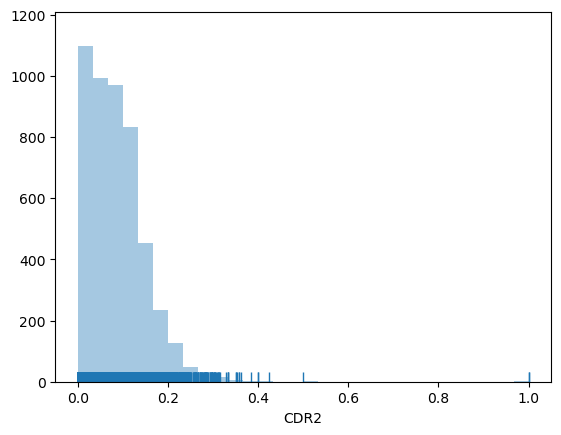

In [47]:
# Plot the distribution of CDR2
sns.distplot(df_processed['CDR2'], bins=30, kde=False, rug=True)

In [48]:
# descriptive statistics of CDR2
df_processed['CDR2'].describe()

count    4821.000000
mean        0.084823
std         0.065413
min         0.000000
25%         0.036792
50%         0.078000
75%         0.123241
max         1.000000
Name: CDR2, dtype: float64

In [49]:
# drop observations with CDR2 = 1 because they are outliers
df_processed = df_processed[df_processed['CDR2'] != 1]
df_processed.shape

df_clean = df_clean[df_clean['CDR2'] != 1]
df_clean.shape

(4819, 102)

In [50]:
df_processed['CDR2'].describe()

count    4819.000000
mean        0.084443
std         0.062713
min         0.000000
25%         0.036562
50%         0.078000
75%         0.123241
max         0.500000
Name: CDR2, dtype: float64

In [51]:
# group by CONTROL and calculate the mean of CDR2
# 1 - public
# 2 - private nonprofit
# 3 - private for-profit

df_clean.groupby(['CONTROL'])['CDR2'].mean()
# private for-profit has the highest CDR2

CONTROL
1    0.097108
2    0.052150
3    0.100284
Name: CDR2, dtype: float64

In [52]:
# group by HIGHDEG and calculate the mean of CDR2
# 0 - non-degree-granting
# 1 - certificate degree
# 2 - associate degree
# 3 - bachelor's degree
# 4 - graduate degree

df_clean.groupby(['HIGHDEG'])['CDR2'].mean()
# associate degree has the highest CDR2

HIGHDEG
0    0.096877
1    0.090601
2    0.116519
3    0.078884
4    0.057476
Name: CDR2, dtype: float64

In [53]:
# group by STABBR and calculate the mean of CDR2
# STABBR = state abbreviation

df_clean.groupby(['STABBR'])['CDR2'].mean().\
    sort_values(ascending=False)
# NV has the highest CDR2

STABBR
NV    0.129430
NM    0.127671
VI    0.127000
KY    0.124608
WY    0.113900
TX    0.112484
AR    0.112159
WV    0.109144
DC    0.105429
SC    0.103754
CO    0.102129
AZ    0.101418
HI    0.095275
MO    0.095102
AL    0.093592
OK    0.093523
ID    0.093017
LA    0.092486
FL    0.091452
OH    0.090840
NC    0.089234
MD    0.088230
MS    0.087679
KS    0.086591
OR    0.086193
CA    0.085309
MP    0.084823
MH    0.084823
FM    0.084823
MI    0.084399
PR    0.084235
AK    0.084203
ME    0.082955
WA    0.082851
GA    0.082714
IN    0.082638
IA    0.081840
DE    0.079616
MT    0.078563
NH    0.077988
VA    0.076165
IL    0.073402
MN    0.073181
PA    0.072269
NJ    0.071370
GU    0.070882
TN    0.069966
CT    0.069414
WI    0.066621
NY    0.061661
MA    0.061598
VT    0.059667
ND    0.055928
NE    0.055441
SD    0.055126
UT    0.054068
RI    0.047855
PW    0.000000
AS    0.000000
Name: CDR2, dtype: float64

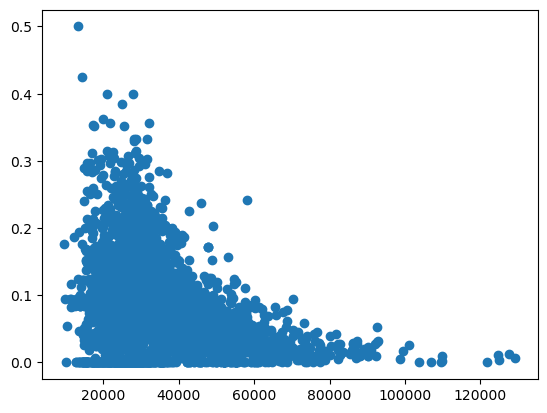

In [54]:
plt.scatter(y='CDR2', x = 'MD_EARN_WNE_MALE0_P8', data = df_clean)

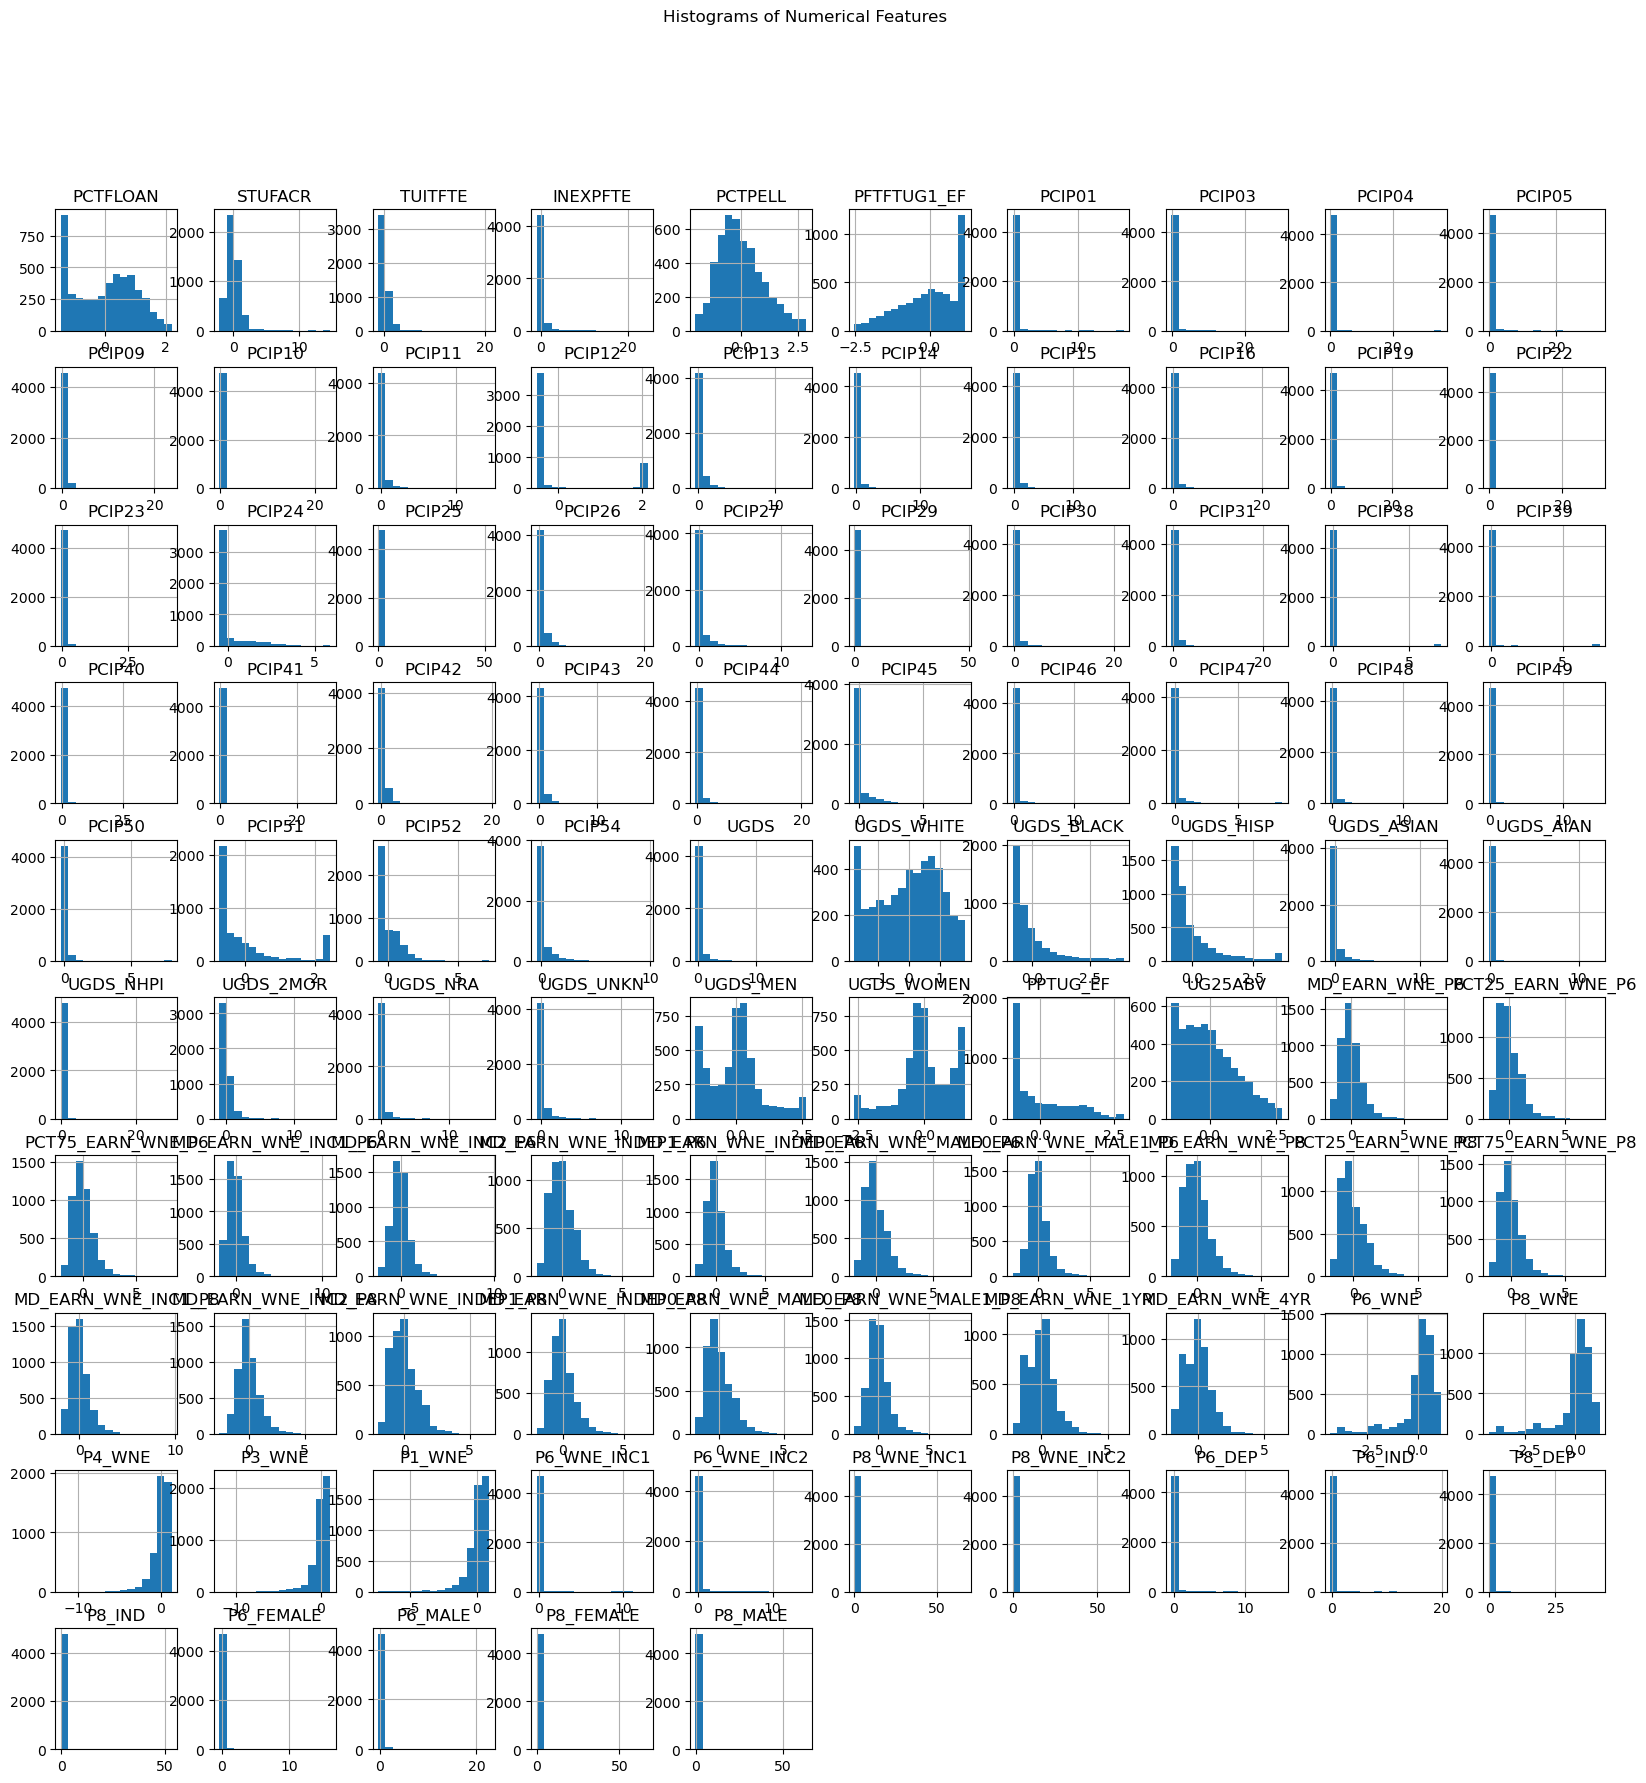

In [55]:
# Histograms for all numerical features
df_processed[numeric_cols].hist(bins=15, figsize=(20, 20))
plt.suptitle('Histograms of Numerical Features')
plt.show()

In [56]:
# correlation between CDR2 and other numeric columns 
correlation_series = df_processed.corr()['CDR2'].sort_values(ascending=False)
correlation_series.head(20)

CDR2          1.000000
HIGHDEG_2     0.279016
PCIP24        0.222938
PCTPELL       0.191193
PPTUG_EF      0.183277
STUFACR       0.178453
CONTROL_3     0.172712
UGDS_BLACK    0.169658
UG25ABV       0.167335
STABBR_TX     0.111697
PCIP15        0.111052
UGDS_HISP     0.108868
PCIP12        0.104364
PCIP43        0.097472
PCIP47        0.080765
UGDS_WOMEN    0.077426
STABBR_KY     0.077200
HIGHDEG_1     0.067949
UNITID        0.067448
PCIP48        0.064172
Name: CDR2, dtype: float64

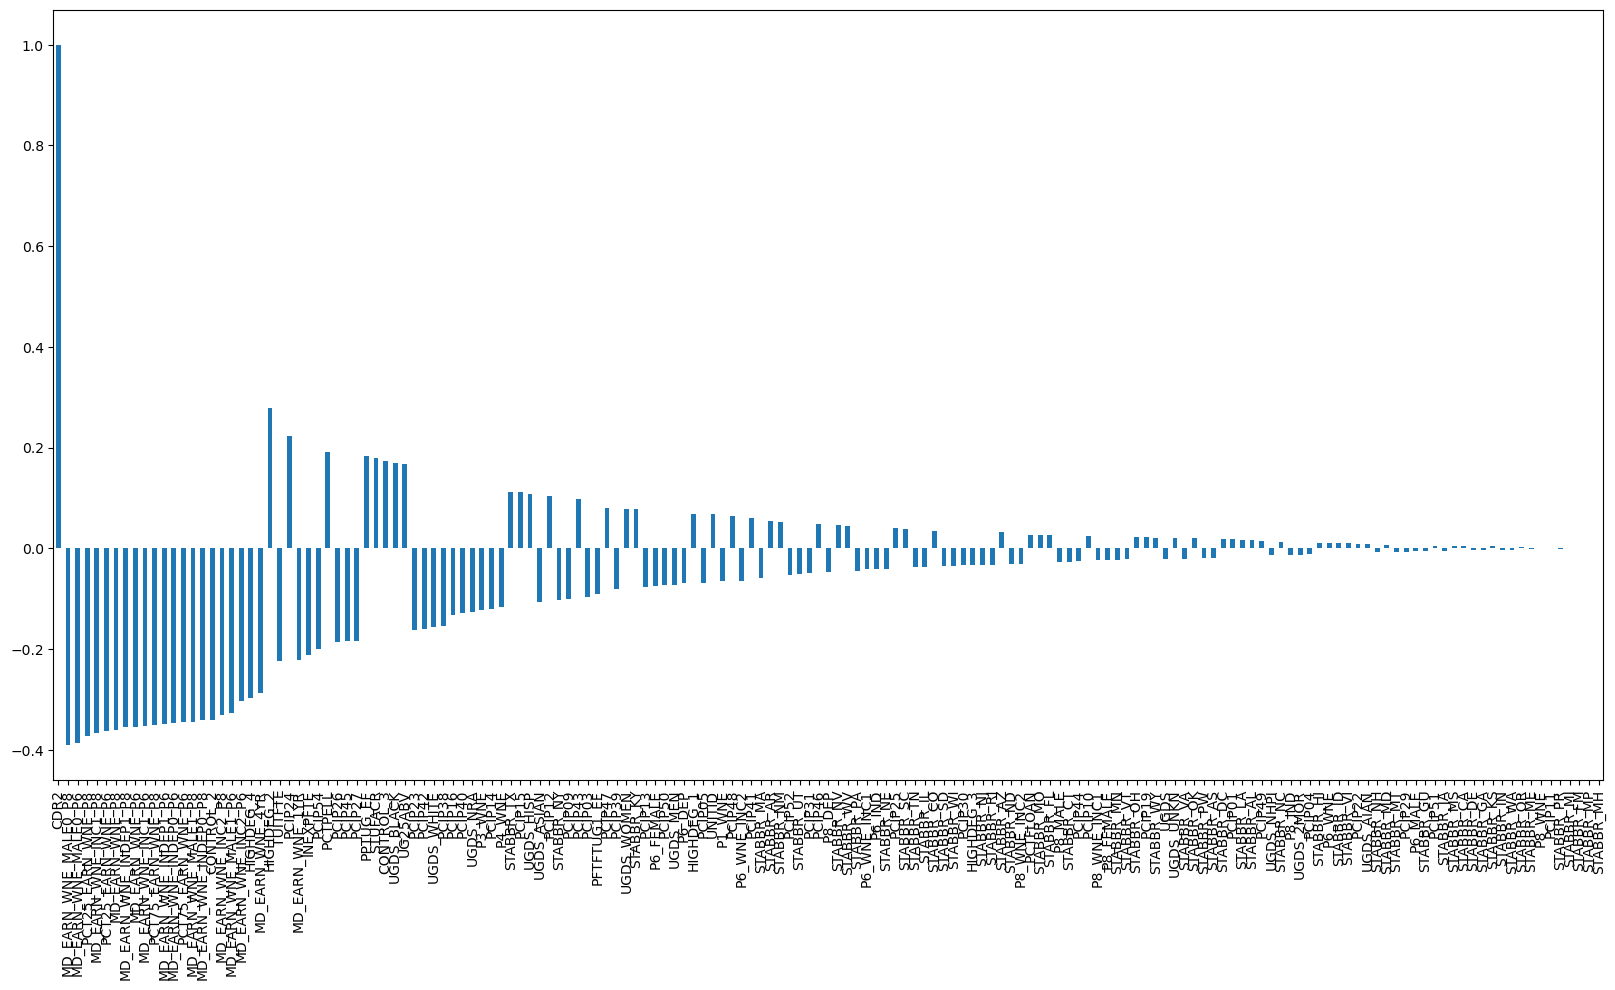

In [57]:
# plot the correlation between CDR2 and other numeric columns
plt.figure(figsize=(20, 10)) 
df_processed.corr()['CDR2'].sort_values(ascending=False, key=abs).plot(kind='bar')
plt.show()


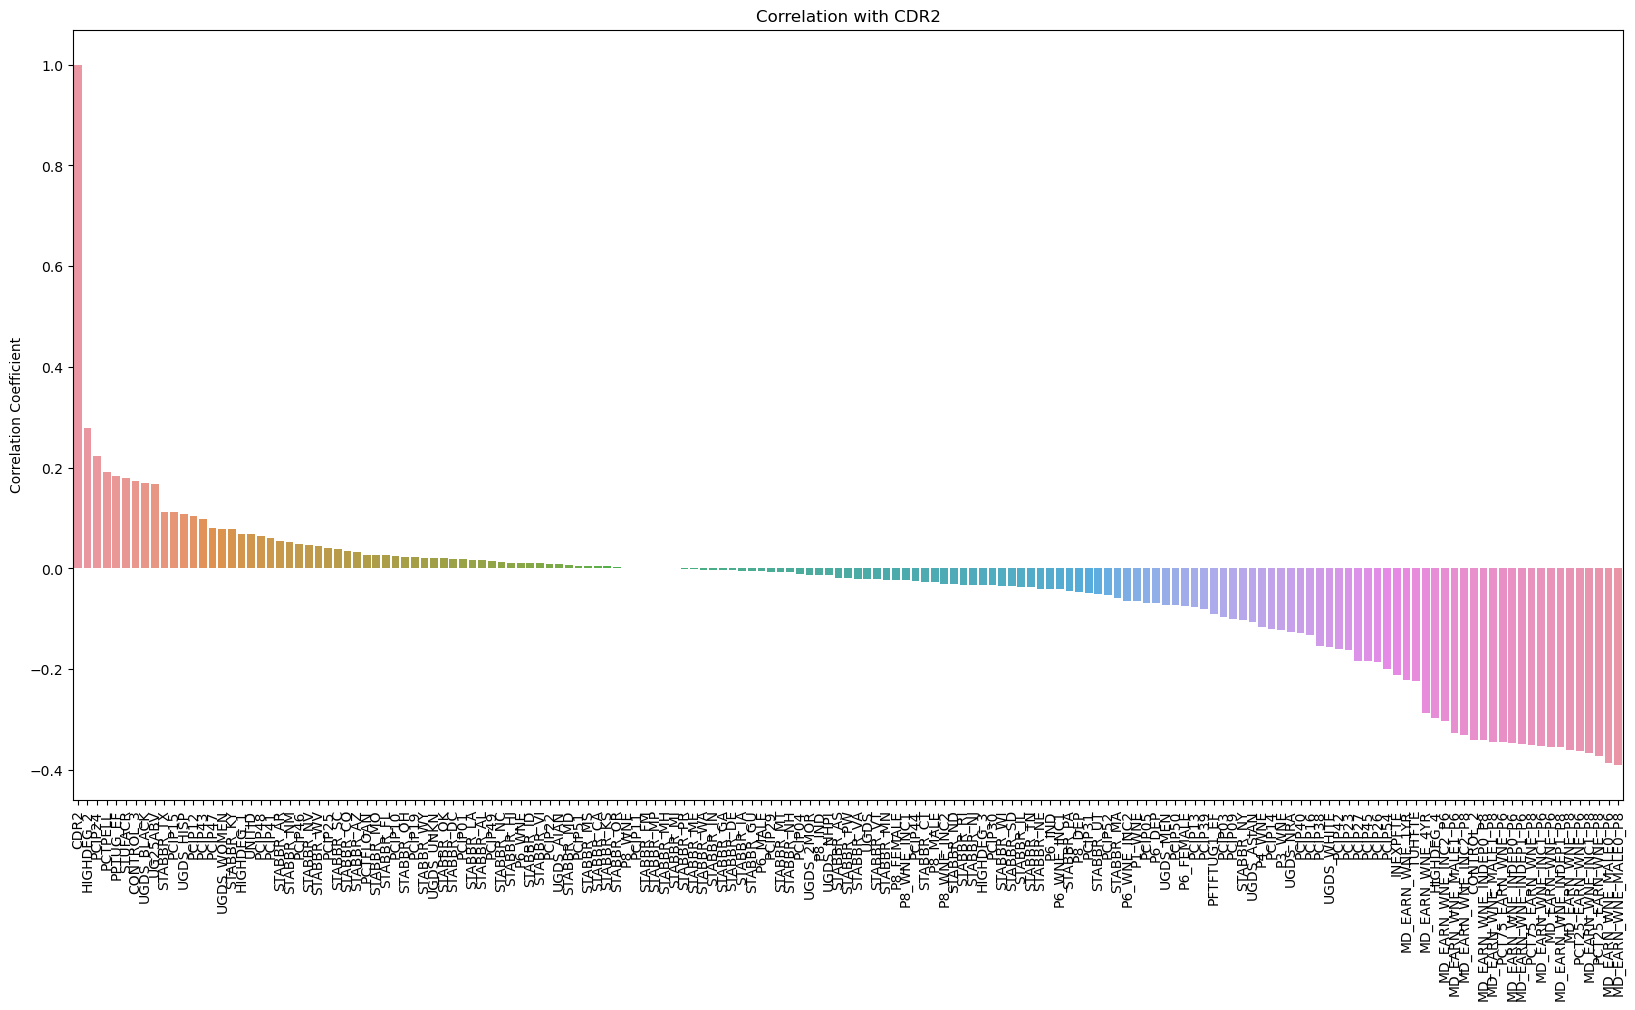

In [58]:
# Create a bar plot of correlation between CDR2 and other numeric columns
plt.figure(figsize=(20, 10))  
sns.barplot(x=correlation_series.index, y=correlation_series.values)
plt.xticks(rotation=90) 
plt.ylabel('Correlation Coefficient')
plt.title('Correlation with CDR2')
plt.show()


In [59]:
# select absolute correlation > 0.1
correlation_series1 = df_processed.corr()['CDR2'][(abs(df_processed.corr()['CDR2']) > 0.1) 
                                                  & (df_processed.corr()['CDR2'] != 1)].sort_values(ascending=False)
correlation_series1.head(10)

HIGHDEG_2     0.279016
PCIP24        0.222938
PCTPELL       0.191193
PPTUG_EF      0.183277
STUFACR       0.178453
CONTROL_3     0.172712
UGDS_BLACK    0.169658
UG25ABV       0.167335
STABBR_TX     0.111697
PCIP15        0.111052
Name: CDR2, dtype: float64

In [60]:
correlation_series1.tail(10)

PCT75_EARN_WNE_P8       -0.350828
MD_EARN_WNE_INC1_P6     -0.352272
MD_EARN_WNE_P6          -0.354718
MD_EARN_WNE_INDEP1_P8   -0.355556
MD_EARN_WNE_P8          -0.360237
PCT25_EARN_WNE_P6       -0.362753
MD_EARN_WNE_INC1_P8     -0.367393
PCT25_EARN_WNE_P8       -0.372205
MD_EARN_WNE_MALE0_P6    -0.386130
MD_EARN_WNE_MALE0_P8    -0.389705
Name: CDR2, dtype: float64

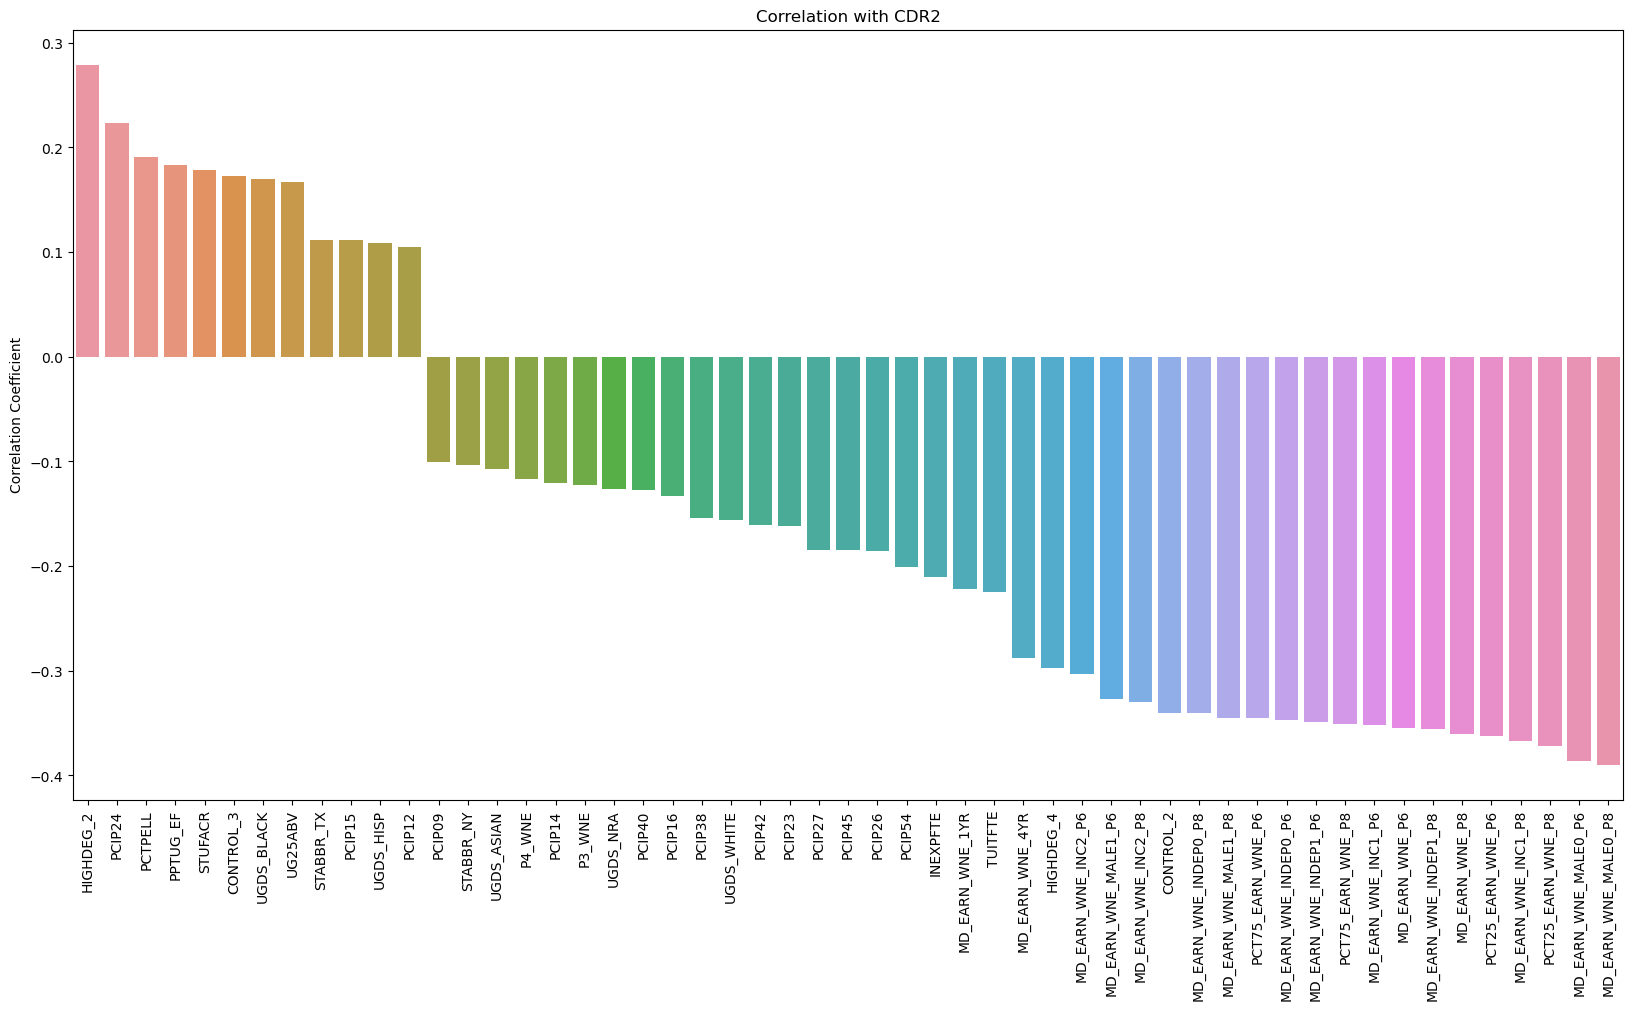

In [61]:
# Create a bar plot of correlation between CDR2 and other numeric columns
plt.figure(figsize=(20, 10))  
sns.barplot(x=correlation_series1.index, y=correlation_series1.values)
plt.xticks(rotation=90)
plt.ylabel('Correlation Coefficient')
plt.title('Correlation with CDR2')
plt.show()

----

In [62]:
# train-test split
X = df_processed.drop(['CDR2', 'UNITID', 'INSTNM'], axis=1)
y = df_processed['CDR2']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)

In [63]:
# matrix transformation
model = MS(X_train, intercept = False) 
D = model.fit_transform(X_train)
feature_names = list(D.columns)
X_train = np.array(D)

model = MS(X_test, intercept = False)
D = model.fit_transform(X_test)
X_test = np.array(D)

----
### **Feature Selection**

First, we used decision tree regressor, lasso, and forward selection to select important features.

----
#### Decision Tree Regressor

This model takes over an hour to run.

In [ ]:
# fit a decision tree regressor
dt = DTR()

# define ccp path
ccp_path = dt.cost_complexity_pruning_path(X_train, y_train)

# define kfold = 5
kfold = KFold(n_splits=5, 
              shuffle=True, 
              random_state = 42)

# grid search for best parameters
grid = skm.GridSearchCV(dt, 
                        {'ccp_alpha': ccp_path.ccp_alphas}, 
                        cv=kfold,
                        scoring='neg_mean_squared_error')

# fit the grid search
G = grid.fit(X_train, y_train)

# print best parameters
best_ = grid.best_estimator_
print('The optimal level of tree complexity is', best_.ccp_alpha)

# print training and test MSE
print('The training MSE is', mean_squared_error(y_train, best_.predict(X_train)))
print('The test MSE is', mean_squared_error(y_test, best_.predict(X_test)))

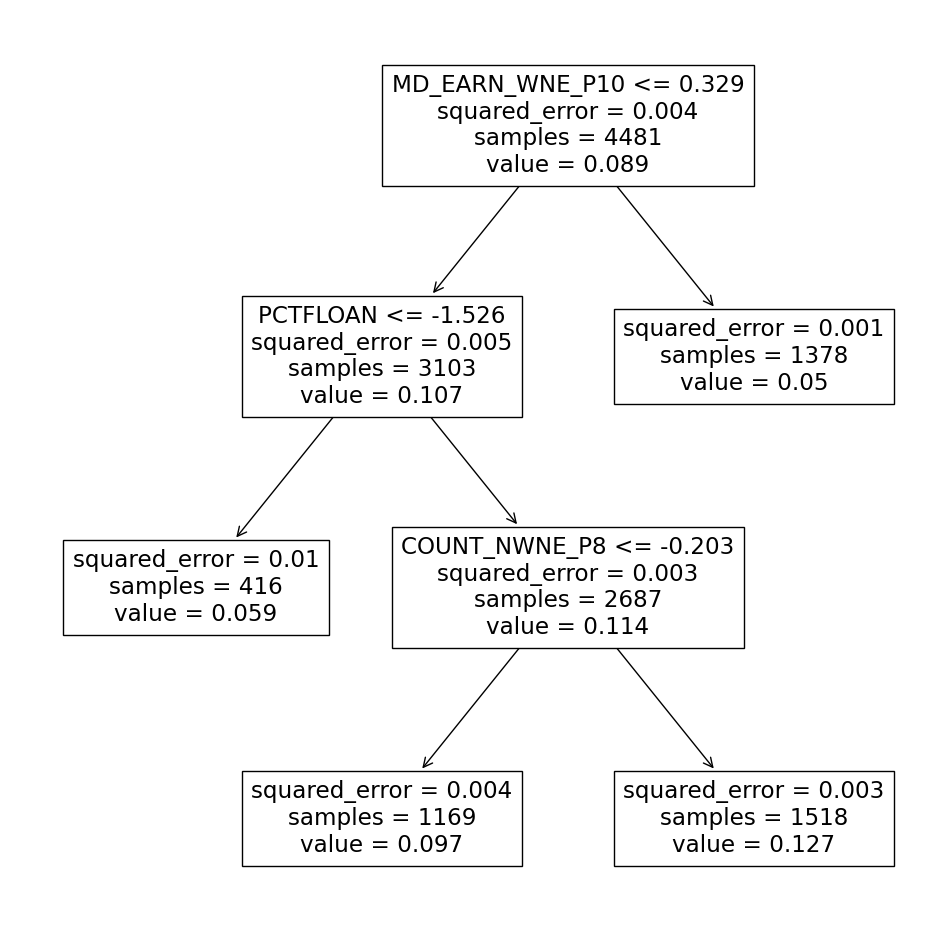

In [ ]:
ax = subplots(figsize=(12,12))[1] 

plot_tree(best_, 
          feature_names=feature_names, 
          ax=ax);

In [ ]:
feature_imp = pd.DataFrame({'importance':best_.feature_importances_}, index = feature_names)
feature_imp.sort_values(by='importance', ascending=False).head()

,importance
MD_EARN_WNE_P10,0.648967
PCTFLOAN,0.225279
COUNT_NWNE_P8,0.125755
STABBR_MT,0.000000
STABBR_MS,0.000000


---
#### PCR

For dimensional reduction, we used PCR. This model yielded higher MSE comparing to Lasso and Forward selection, so we will not be proceed with this model's results. 

In [115]:
X_train_cons = sm.add_constant(X_train)
pca = PCA()
pca.fit(X_train_cons)

PCA()

In [116]:
num_components = np.arange(20, 201, 20)

linreg = skl.LinearRegression()
pipe3 = Pipeline([('pca', pca), ('linreg', linreg)])
pipe3.fit(X_train, y_train)

param_grid = {'pca__n_components': num_components} 
grid = skm.GridSearchCV(pipe3, param_grid , 
                        cv = kfold, 
                        scoring='neg_mean_squared_error') 
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200])},
             scoring='neg_mean_squared_error')

In [117]:
# calculae training and test MSE
train_pred = grid.predict(X_train)
train_MSE = np.mean((y_train - train_pred)**2)

test_pred = grid.predict(X_test)
test_MSE = np.mean((y_test - test_pred)**2)

# print it out
print(f"Training MSE: {train_MSE}")
print(f"Testing MSE: {test_MSE}")

Training MSE: 0.0028870665577801114
Testing MSE: 0.002815421554211848


----
#### Forward Selection

In [64]:
X = df_processed.drop(['CDR2', 'UNITID', 'INSTNM'], axis=1)
y = df_processed['CDR2']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)

X_train_cons = X_train.copy()
X_train_cons['const'] = 1.0

X_test_cons = X_test.copy()
X_test_cons['const'] = 1.0

In [65]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate rsquared
    if 'const' not in feature_set:
        feature_set = feature_set + ('const',) # mannually add intercept
    model = sm.OLS(y_train, X_train_cons[list(feature_set)])
    regr = model.fit()
    rsquared = regr.rsquared
    return {"model":regr, "rsquared":rsquared}

In [66]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(tuple(predictors+[p])))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest rsquared
    best_model = models.loc[models['rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [67]:
models_fwd = pd.DataFrame(columns=["rsquared", "model"])

tic = time.time()
predictors = []

for i in range(1,40):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  159 models on 1 predictors in 0.06766104698181152 seconds.
Processed  158 models on 3 predictors in 0.2417430877685547 seconds.
Processed  157 models on 4 predictors in 0.332446813583374 seconds.
Processed  156 models on 5 predictors in 0.5034329891204834 seconds.
Processed  155 models on 6 predictors in 0.10639309883117676 seconds.
Processed  154 models on 7 predictors in 0.21016407012939453 seconds.
Processed  153 models on 8 predictors in 0.21020078659057617 seconds.
Processed  152 models on 9 predictors in 0.3381533622741699 seconds.
Processed  151 models on 10 predictors in 0.3286399841308594 seconds.
Processed  150 models on 11 predictors in 0.42555713653564453 seconds.
Processed  149 models on 12 predictors in 0.6422548294067383 seconds.
Processed  148 models on 13 predictors in 0.6073591709136963 seconds.
Processed  147 models on 14 predictors in 0.7101147174835205 seconds.
Processed  146 models on 15 predictors in 0.614434003829956 seconds.
Processed  145 models on 

In [68]:
# forward selection with 40 predictors
print(models_fwd.loc[39, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                   CDR2   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     46.24
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          3.16e-286
Time:                        15:51:39   Log-Likelihood:                 5930.0
No. Observations:                3855   AIC:                        -1.178e+04
Df Residuals:                    3815   BIC:                        -1.153e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
MD_EARN_WNE_MALE0_P8     -0.00

In [69]:
# Get the selected features from the best model
selected_features = models_fwd.loc[39, "model"].model.exog_names

# Select only the relevant features from the training and test datasets
X_train_selected = X_train_cons[selected_features]
X_test_selected = X_test_cons[selected_features]

# Calculate train and test MSE using the selected features
print('The training MSE is', mean_squared_error(y_train, models_fwd.loc[39, "model"].predict(X_train_selected)))
print('The test MSE is', mean_squared_error(y_test, models_fwd.loc[39, "model"].predict(X_test_selected)))

The training MSE is 0.0027003180388076283
The test MSE is 0.002600706528686517


----
#### Lasso Regression

In [70]:
#Lasso
lambdas = 10 ** np.linspace(4, -6, 101)

# define kfold = 5
kfold = KFold(n_splits = 5, 
              shuffle = True, 
              random_state = 0)

lassoCV = skl.ElasticNetCV(alphas = lambdas,
                           l1_ratio=1,
                           cv=kfold)

scaler = StandardScaler(with_mean=True, with_std=True)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])

pipeCV.fit(X_train, y_train)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.0003981071705534969

In [71]:
# coefficients and lambda
Xs = X_train - X_train.mean(0)[None,:]
X_scale = X_train.std(0)
Xs = Xs / X_scale[None,:]
soln_array = skl.ElasticNet.path(Xs, y_train, 
                                 l1_ratio = 1, 
                                 alphas=lambdas)[1]
# soln_array

soln_path = pd.DataFrame(soln_array.T, columns = feature_names, index = -np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path.head()

,PCTFLOAN,STUFACR,TUITFTE,INEXPFTE,PCTPELL,PFTFTUG1_EF,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,UGDS_UNKN,UGDS_MEN,UGDS_WOMEN,PPTUG_EF,UG25ABV,MD_EARN_WNE_P6,PCT25_EARN_WNE_P6,PCT75_EARN_WNE_P6,MD_EARN_WNE_INC1_P6,MD_EARN_WNE_INC2_P6,MD_EARN_WNE_INDEP1_P6,MD_EARN_WNE_INDEP0_P6,MD_EARN_WNE_MALE0_P6,MD_EARN_WNE_MALE1_P6,MD_EARN_WNE_P8,PCT25_EARN_WNE_P8,PCT75_EARN_WNE_P8,MD_EARN_WNE_INC1_P8,MD_EARN_WNE_INC2_P8,MD_EARN_WNE_INDEP1_P8,MD_EARN_WNE_INDEP0_P8,MD_EARN_WNE_MALE0_P8,MD_EARN_WNE_MALE1_P8,MD_EARN_WNE_1YR,MD_EARN_WNE_4YR,P6_WNE,P8_WNE,P4_WNE,P3_WNE,P1_WNE,P6_WNE_INC1,P6_WNE_INC2,P8_WNE_INC1,P8_WNE_INC2,P6_DEP,P6_IND,P8_DEP,P8_IND,P6_FEMALE,P6_MALE,P8_FEMALE,P8_MALE,STABBR_AL,STABBR_AR,STABBR_AS,STABBR_AZ,STABBR_CA,STABBR_CO,STABBR_CT,STABBR_DC,STABBR_DE,STABBR_FL,STABBR_FM,STABBR_GA,STABBR_GU,STABBR_HI,STABBR_IA,STABBR_ID,STABBR_IL,STABBR_IN,STABBR_KS,STABBR_KY,STABBR_LA,STABBR_MA,STABBR_MD,STABBR_ME,STABBR_MH,STABBR_MI,STABBR_MN,STABBR_MO,STABBR_MP,STABBR_MS,STABBR_MT,STABBR_NC,STABBR_ND,STABBR_NE,STABBR_NH,STABBR_NJ,STABBR_NM,STABBR_NV,STABBR_NY,STABBR_OH,STABBR_OK,STABBR_OR,STABBR_PA,STABBR_PR,STABBR_PW,STABBR_RI,STABBR_SC,STABBR_SD,STABBR_TN,STABBR_TX,STABBR_UT,STABBR_VA,STABBR_VI,STABBR_VT,STABBR_WA,STABBR_WI,STABBR_WV,STABBR_WY,CONTROL_2,CONTROL_3,HIGHDEG_1,HIGHDEG_2,HIGHDEG_3,HIGHDEG_4
negative log(lambda),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-9.210340,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
-8.980082,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0
-8.749823,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0

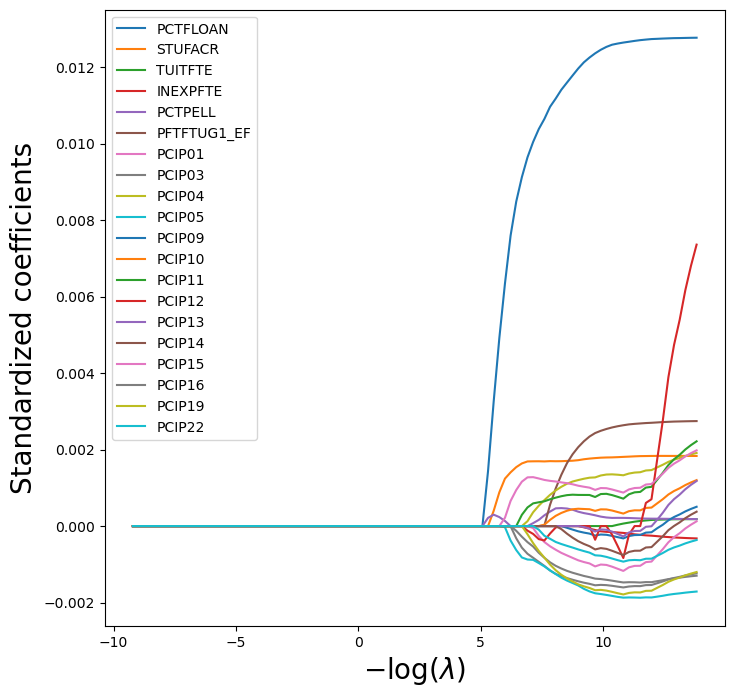

In [72]:
# draw the coefficient path of the top 20 features
path_fig, ax = subplots(figsize=(8,8))
soln_path.iloc[:,:20].plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [73]:
#refit with optimal lambda
lasso = skl.ElasticNet(alpha = tuned_lasso.alpha_,
                       l1_ratio = 1)
pipe = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', ElasticNet(alpha=0.0003981071705534969, l1_ratio=1))])

In [75]:
# print important features
# almost no features are suppressed to 0
feature_imp = pd.DataFrame({'importance':pipe.named_steps['lasso'].coef_}, index = feature_names)
# order by absolute value
feature_imp = feature_imp.reindex(feature_imp['importance'].abs().sort_values(ascending=False).index)
feature_imp

,importance
PCTFLOAN,0.010960
CONTROL_2,-0.009579
PCIP24,0.006797
PCT25_EARN_WNE_P6,-0.005931
PCT25_EARN_WNE_P8,-0.005581
MD_EARN_WNE_MALE0_P6,-0.005562
STABBR_KY,0.005222
HIGHDEG_4,-0.004671
MD_EARN_WNE_MALE0_P8,-0.004561
HIGHDEG_2,0.004406


In [76]:
train_pred = pipe.predict(X_train)
train_MSE = np.mean((y_train - train_pred)**2)

test_pred = pipe.predict(X_test)
test_MSE = np.mean((y_test - test_pred)**2)

print(f"Training MSE: {train_MSE}")
print(f"Testing MSE: {test_MSE}")

Training MSE: 0.002671116092788948
Testing MSE: 0.002558603813083792


In [78]:
# use a bigger alpha as we want more shrinkage
lasso = skl.ElasticNet(alpha = 0.002,
                       l1_ratio = 1)
pipe2 = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
pipe2.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', ElasticNet(alpha=0.002, l1_ratio=1))])

In [79]:
train_pred = pipe2.predict(X_train)
train_MSE = np.mean((y_train - train_pred)**2)

test_pred = pipe2.predict(X_test)
test_MSE = np.mean((y_test - test_pred)**2)

print(f"Training MSE: {train_MSE}")
print(f"Testing MSE: {test_MSE}")
# the test MSE does not differ much from the previous one

Training MSE: 0.002845916247173365
Testing MSE: 0.0026719450022265772


In [80]:
# print top 40 features
feature_imp = pd.DataFrame({'importance':pipe2.named_steps['lasso'].coef_}, index = feature_names)
# order by absolute value
feature_imp = feature_imp.reindex(feature_imp['importance'].abs().sort_values(ascending=False).index)
feature_imp.head(40)

,importance
CONTROL_2,-0.008467
PCTFLOAN,0.007585
HIGHDEG_2,0.007145
PCIP24,0.006324
MD_EARN_WNE_MALE0_P6,-0.005647
PCT25_EARN_WNE_P8,-0.004115
MD_EARN_WNE_MALE0_P8,-0.003646
STABBR_KY,0.003631
STABBR_TX,0.002806
PCIP43,0.002802


In [81]:
# save features that are non-zero
non_zero_features = feature_imp[feature_imp['importance'] != 0].index.tolist()
len(non_zero_features)
# print(non_zero_features)

37

In [82]:
# when we make lambda large enough
lasso = skl.ElasticNet(alpha = 0.01,
                       l1_ratio = 1)
pipe3 = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
pipe3.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', ElasticNet(alpha=0.01, l1_ratio=1))])

In [83]:
# print top 10 features
feature_imp = pd.DataFrame({'importance':pipe3.named_steps['lasso'].coef_}, index = feature_names)
# order by absolute value
feature_imp = feature_imp.reindex(feature_imp['importance'].abs().sort_values(ascending=False).index)
feature_imp.head(10)

,importance
MD_EARN_WNE_MALE0_P8,-0.005762
MD_EARN_WNE_MALE0_P6,-0.005193
CONTROL_2,-0.004917
HIGHDEG_2,0.003378
PCT25_EARN_WNE_P8,-0.001345
PCIP24,0.000020
STABBR_HI,0.000000
STABBR_DC,0.000000
STABBR_DE,0.000000
STABBR_FL,0.000000


In [84]:
# if we only look at the number of features that's the same as the number chosen by lasso when we used a large enough lambda
# the important features chosen by these 2 models are very similar
print(models_fwd.loc[6, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                   CDR2   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     217.6
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          8.31e-240
Time:                        15:55:46   Log-Likelihood:                 5747.1
No. Observations:                3855   AIC:                        -1.148e+04
Df Residuals:                    3848   BIC:                        -1.144e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
MD_EARN_WNE_MALE0_P8    -0.0176 

Therefore, we'd like to use the 37 models chosen by lasso in our following predictive models. 

----
### **Predictive Modeling - Regression**

We then used the features selected by lasso to fit decision tree and random forest regressor to predict the default rate.

----
#### Decision Tree Regressor

In [85]:
# predict CDR2 using the selected features
X = df_processed[non_zero_features]
y = df_processed['CDR2']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=1)

# matrix transformation
model = MS(X_train, intercept = False)
D = model.fit_transform(X_train)
feature_names = list(D.columns)
X_train = np.array(D)

model = MS(X_test, intercept = False)
D = model.fit_transform(X_test)
X_test = np.array(D)

# define ccp path
dt = DTR()
ccp_path = dt.cost_complexity_pruning_path(X_train, y_train)

# define kfold = 5
kfold = KFold(n_splits=5, 
              shuffle=True, 
              random_state = 42)

# grid search for best parameters
grid = skm.GridSearchCV(dt, 
                        {'ccp_alpha': ccp_path.ccp_alphas}, 
                        cv=kfold,
                        scoring='neg_mean_squared_error')

# fit the grid search
G = grid.fit(X_train, y_train)

# print best parameters
best_ = grid.best_estimator_
print('The optimal level of tree complexity is', best_.ccp_alpha)

# print training and test MSE
print('The training MSE is', mean_squared_error(y_train, best_.predict(X_train)))
print('The test MSE is', mean_squared_error(y_test, best_.predict(X_test)))

The optimal level of tree complexity is 3.200925337210713e-05
The training MSE is 0.0026324354719480226
The test MSE is 0.0025152279888084493


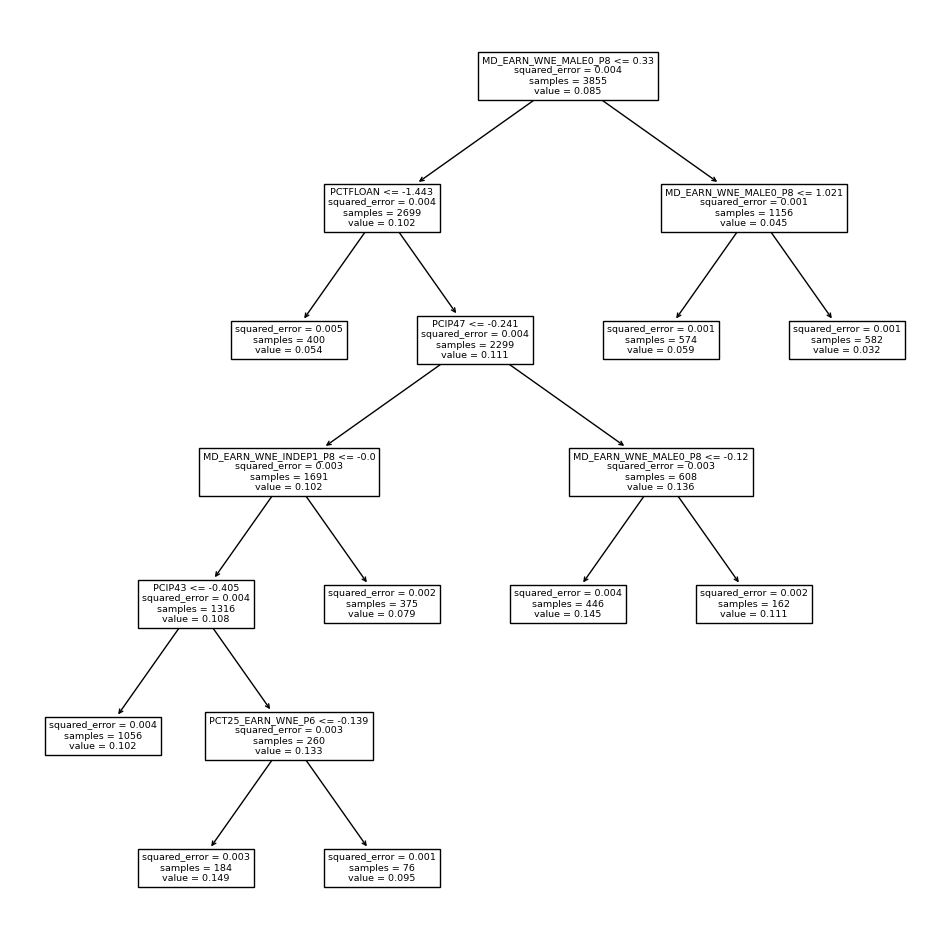

In [86]:
ax = subplots(figsize=(12,12))[1]

plot_tree(best_,
          feature_names = feature_names,
          ax=ax);

In [87]:
# getting the splitting nodes
print(export_text(best_, 
                  feature_names=feature_names,
                  show_weights=True))

|--- MD_EARN_WNE_MALE0_P8 <= 0.33
|   |--- PCTFLOAN <= -1.44
|   |   |--- value: [0.05]
|   |--- PCTFLOAN >  -1.44
|   |   |--- PCIP47 <= -0.24
|   |   |   |--- MD_EARN_WNE_INDEP1_P8 <= -0.00
|   |   |   |   |--- PCIP43 <= -0.41
|   |   |   |   |   |--- value: [0.10]
|   |   |   |   |--- PCIP43 >  -0.41
|   |   |   |   |   |--- PCT25_EARN_WNE_P6 <= -0.14
|   |   |   |   |   |   |--- value: [0.15]
|   |   |   |   |   |--- PCT25_EARN_WNE_P6 >  -0.14
|   |   |   |   |   |   |--- value: [0.09]
|   |   |   |--- MD_EARN_WNE_INDEP1_P8 >  -0.00
|   |   |   |   |--- value: [0.08]
|   |   |--- PCIP47 >  -0.24
|   |   |   |--- MD_EARN_WNE_MALE0_P8 <= -0.12
|   |   |   |   |--- value: [0.14]
|   |   |   |--- MD_EARN_WNE_MALE0_P8 >  -0.12
|   |   |   |   |--- value: [0.11]
|--- MD_EARN_WNE_MALE0_P8 >  0.33
|   |--- MD_EARN_WNE_MALE0_P8 <= 1.02
|   |   |--- value: [0.06]
|   |--- MD_EARN_WNE_MALE0_P8 >  1.02
|   |   |--- value: [0.03]



In [89]:
# print feature importance
feature_imp = pd.DataFrame({'importance':best_.feature_importances_}, index = feature_names)
feature_imp.sort_values(by='importance', ascending=False).head(10)

,importance
MD_EARN_WNE_MALE0_P8,0.571116
PCTFLOAN,0.215760
PCIP47,0.097417
MD_EARN_WNE_INDEP1_P8,0.048676
PCIP43,0.037086
PCT25_EARN_WNE_P6,0.029945
UGDS_NHPI,0.000000
PCIP38,0.000000
HIGHDEG_3,0.000000
PCIP15,0.000000


---
#### Random Forest Regressor

In [90]:
test_MSE = []

for i in range(1,500):
    RF_ = RF(max_features = 5, 
         n_estimators = i,
         random_state = 0).fit(X_train, y_train) 
    y_hat_RF = RF_.predict(X_test)
    # Test MSE
    test_MSE.append(np.mean((y_test - y_hat_RF)**2))

237

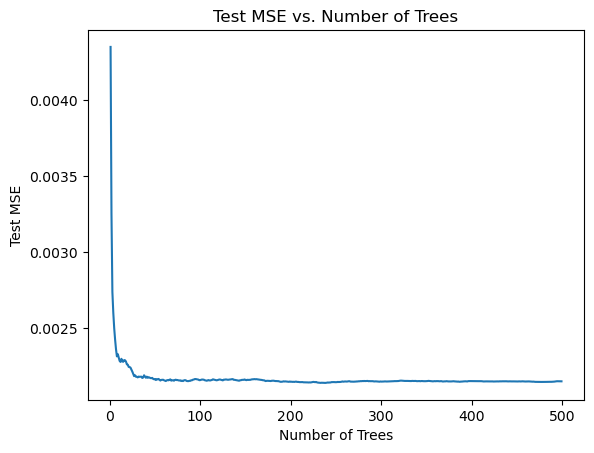

In [91]:
# find the optimal number of trees
plt.plot(range(1,500), test_MSE)
plt.xlabel('Number of Trees')
plt.ylabel('Test MSE')
plt.title('Test MSE vs. Number of Trees');

# find the optimal number of trees
np.argmin(test_MSE) # 237

In [92]:
test_MSE = []

for i in range(1, X_train.shape[1]):
    RF_ = RF(max_features = i, 
            n_estimators = 237,
            random_state = 0).fit(X_train, y_train) 
    y_hat_RF = RF_.predict(X_test)
    # Test accuracy
    test_MSE.append(np.mean((y_test - y_hat_RF)**2))

9

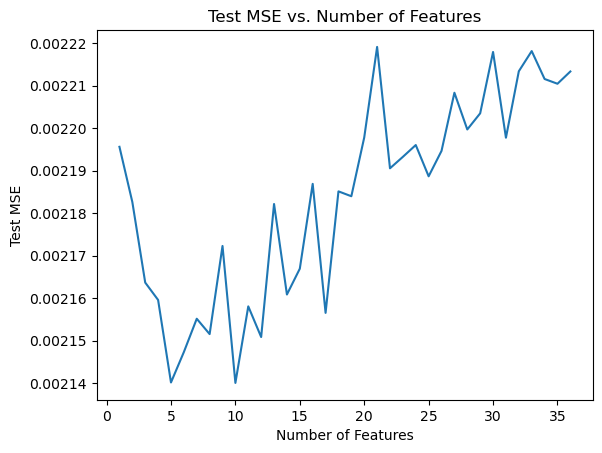

In [93]:
# find the optimal number of features
plt.plot(range(1, X_train.shape[1]), test_MSE)
plt.xlabel('Number of Features')
plt.ylabel('Test MSE')
plt.title('Test MSE vs. Number of Features');

# find the optimal number of features
np.argmin(test_MSE) #9

In [94]:
# fit the model with the best parameters
RF_ = RF(max_features = 9, 
         n_estimators = 237,
         random_state = 0).fit(X_train, y_train)

# print training and test MSE
print('The training MSE is', mean_squared_error(y_train, RF_.predict(X_train)))
print('The test MSE is', mean_squared_error(y_test, RF_.predict(X_test)))

The training MSE is 0.00032301900103473715
The test MSE is 0.002172275064086428


In [95]:
feature_imp = pd.DataFrame( {'importance':RF_.feature_importances_}, index = feature_names)
feature_imp.sort_values(by='importance', ascending = False)

,importance
MD_EARN_WNE_MALE0_P8,0.116426
PCTFLOAN,0.103516
PCT25_EARN_WNE_P8,0.099107
MD_EARN_WNE_MALE0_P6,0.092374
PCT25_EARN_WNE_P6,0.080761
MD_EARN_WNE_INDEP1_P8,0.076649
UGDS_BLACK,0.054688
UGDS_WHITE,0.053945
STUFACR,0.039964
PPTUG_EF,0.036768


----
#### PLS

In [96]:
# grid search for best parameters
grid = skm.GridSearchCV(PLSRegression(scale=True), 
                        {'n_components': range(1, 10)}, 
                        cv=kfold,
                        scoring='neg_mean_squared_error')

# fit the grid search
G = grid.fit(X_train, y_train)

# print best parameters
best_ = grid.best_estimator_
print('The optimal number of components is', best_.n_components)

# print training and test MSE
print('The training MSE is', mean_squared_error(y_train, best_.predict(X_train)))
print('The test MSE is', mean_squared_error(y_test, best_.predict(X_test)))

The optimal number of components is 7
The training MSE is 0.0027327981664150595
The test MSE is 0.0026206171221409046


----
### **Classification**

In commercial law, a holder in due course (HDC) is someone who takes a negotiable instrument in a value-for-value exchange without reason to doubt that the instrument will be paid. In other words, HDC is a person or institution that receives a negotiable instrument, such as a check or promissory note, in exchange for value. The HDC must receive the instrument in good faith, without any reason to doubt that it will be paid. The HDC doctrine protects a purchaser of debt. The purchaser is assigned the right to receive the debt payments. If the stated value of the instrument was fraudulent, the HDC can claim its original value from the person or entity that provided it. Claiming bankruptcy will not free the borrower from the duty of paying off the debt. Federal forgiveness of student loans will not apply either. 

Sallie Mae Corporation is a publicly traded U.S. corporation that provides consumer banking. Its nature has changed dramatically since it was set up in the early 1970s; initially, a government entity that serviced federal education loans, it then became private and began offering private student loans. It was notorious for Sallie Mae to bribe Congress to make the HDC applicable to student loans. Therefore, the threshold for issuing a loan to a student will be very low regarding the probability of default since only death can free people from the duty to pay off the loan.

In [97]:
# set a threshold for CDR2
df_processed['CDR2'].describe()

count    4819.000000
mean        0.084443
std         0.062713
min         0.000000
25%         0.036562
50%         0.078000
75%         0.123241
max         0.500000
Name: CDR2, dtype: float64

In [98]:
# for CDR2 > 0.1, turn it into 1
df_processed['Default2'] = np.where(df_processed['CDR2'] > 0.1, 1, 0)

In [99]:
# a new y with categorical values
y_default = df_processed['Default2']
# a new X with the same features
X_default = df_processed[non_zero_features]

# train-test split
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_default, y_default,
                                                            test_size=0.3, 
                                                            random_state=1)

In [100]:
y_train_d.value_counts()

0    2155
1    1218
Name: Default2, dtype: int64

In [101]:
# change y_train_d and y_test_d to category
y_train_d = y_train_d.astype('category')
y_test_d = y_test_d.astype('category')

---
#### Decision Tree Classifier

In [103]:
# prune max depth
dtc = DTC(criterion='entropy') 

grid = skm.GridSearchCV(dtc, 
                        {'max_depth': range(0, 20)}, 
                        cv=kfold,
                        scoring='accuracy')

# fit the grid search
G = grid.fit(X_train_d, y_train_d)

# print best parameters
best_dtc = grid.best_estimator_
print('The optimal depth is', best_dtc.max_depth)

The optimal depth is 6


In [104]:
# print training and test accuracy
print('The training accuracy is', accuracy_score(y_train_d, best_dtc.predict(X_train_d)))
print('The test accuracy is', accuracy_score(y_test_d, best_dtc.predict(X_test_d)))

The training accuracy is 0.7969166913726653
The test accuracy is 0.7510373443983402


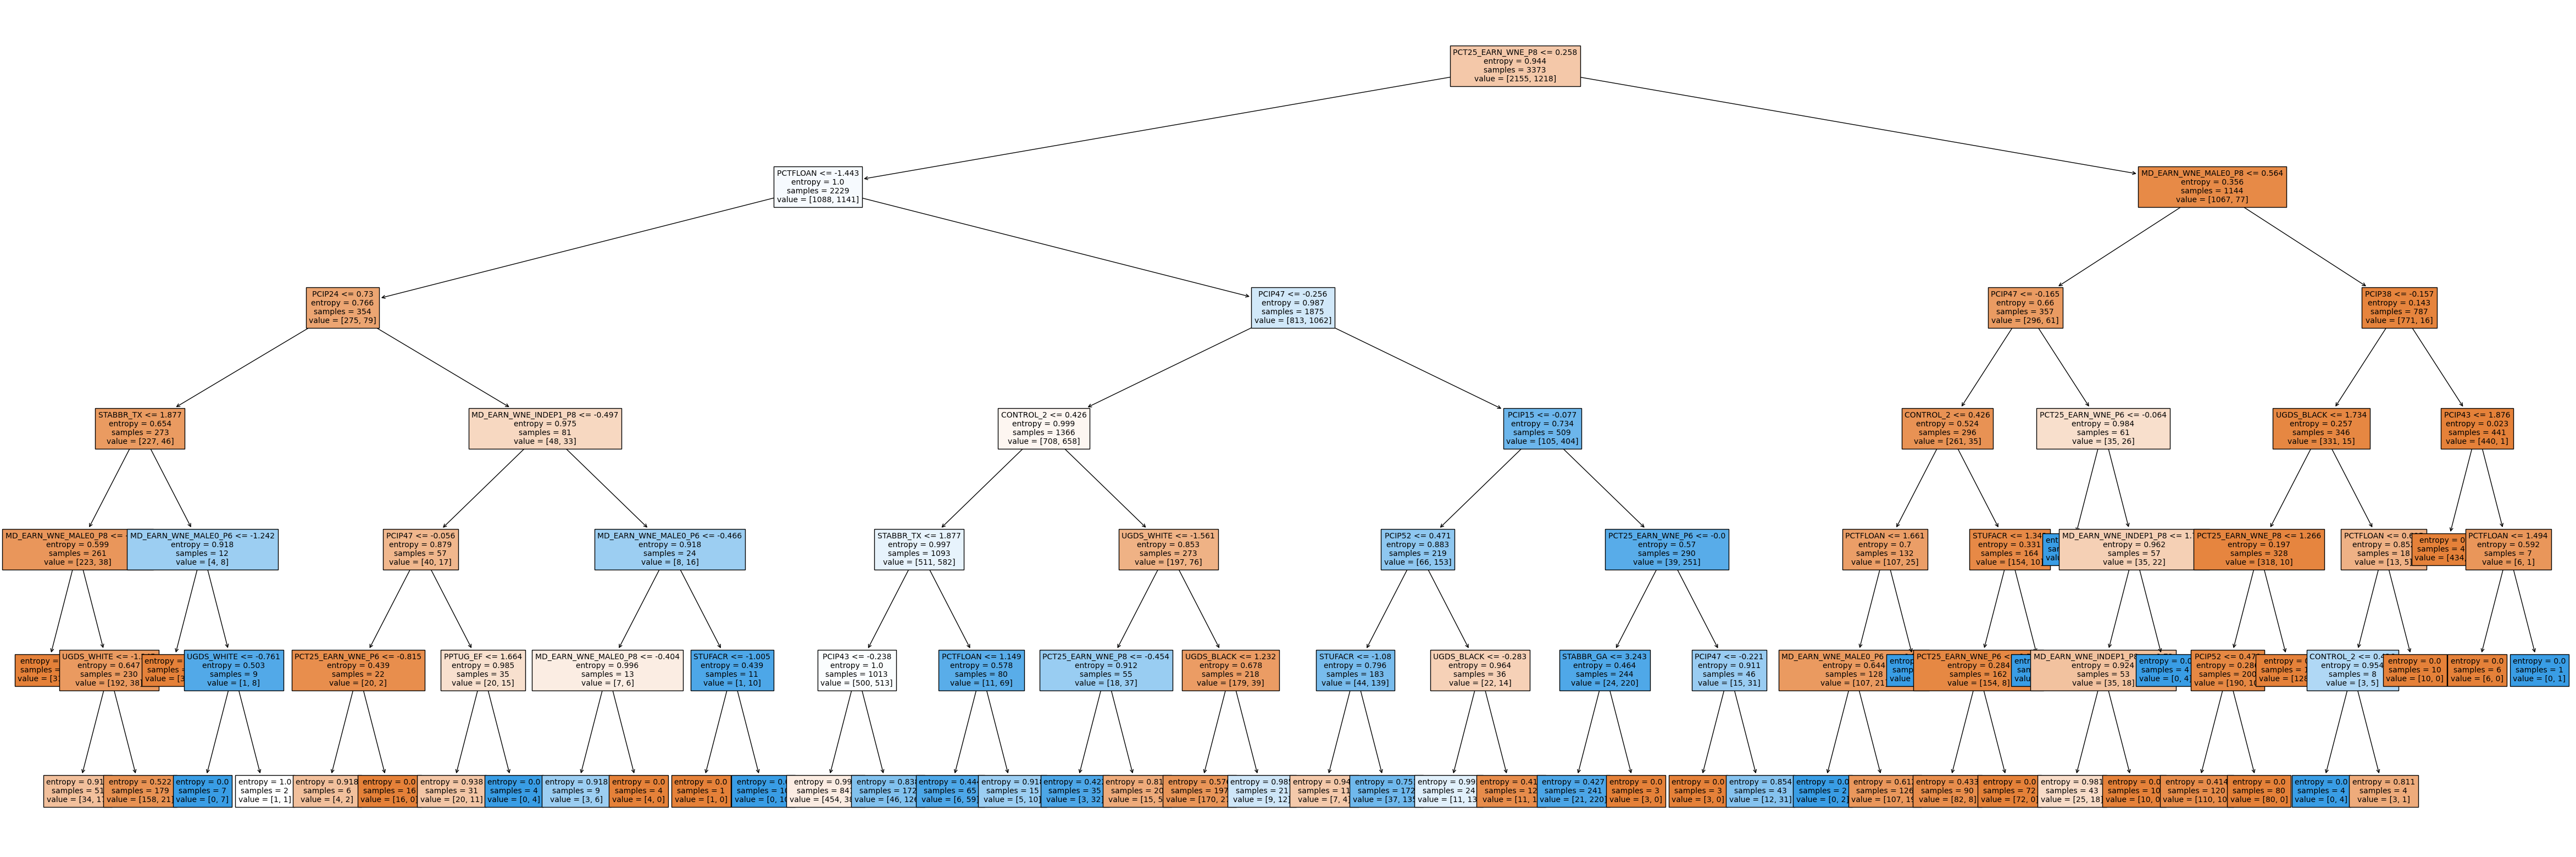

In [106]:
# We can visualize the tree

from sklearn.tree import plot_tree
plt.figure(figsize=(60,20))
plot_tree(best_dtc, filled=True, feature_names = feature_names, fontsize=10)
plt.show()

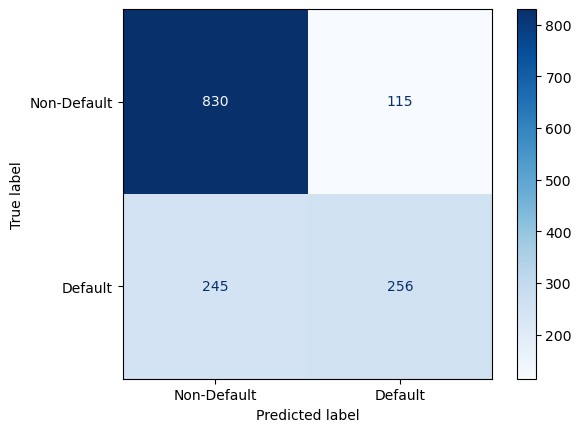

In [107]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test_d, best_dtc.predict(X_test_d))
display_labels = ['Non-Default', 'Default'] 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues');

----
#### Random Forest

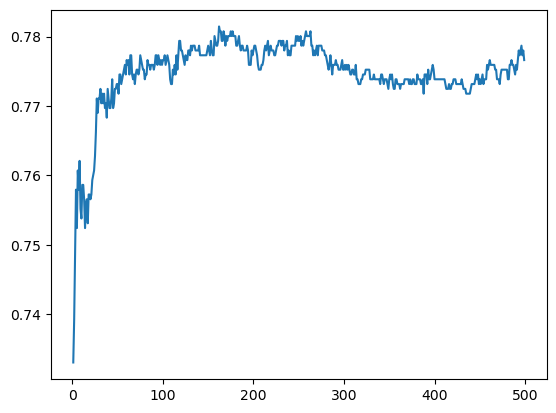

In [108]:
test_accuracy = []

for i in range(1,500):
    rfc = RFC(max_features = 5, 
              max_depth = 6,
              n_estimators = i,
              random_state = 0).fit(X_train_d, y_train_d) 
    y_hat_rfc = rfc.predict(X_test_d)
    # Test accuracy
    test_accuracy.append(accuracy_score(y_test_d, y_hat_rfc))

# find the optimal number of trees
plt.plot(range(1,500), test_accuracy)

In [109]:
# find out the number of tree with the highest accuracy
print(max(test_accuracy))
print(test_accuracy.index(max(test_accuracy)) + 1)

0.7814661134163209
162


0.7814661134163209
5


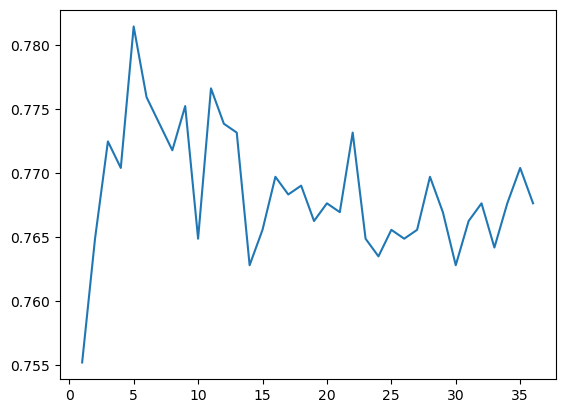

In [110]:
test_accuracy = []

for i in range(1, X_train_d.shape[1]):
    rfc = RFC(max_depth = 6,
              max_features = i, 
              n_estimators = 162,
              random_state = 0).fit(X_train_d, y_train_d) 
    y_hat_rfc = rfc.predict(X_test_d)
    # Test accuracy
    test_accuracy.append(accuracy_score(y_test_d, y_hat_rfc))

# find the optimal number of features
plt.plot(range(1, X_train_d.shape[1]), test_accuracy)

# find out the number of features with the highest accuracy
print(max(test_accuracy))
print(test_accuracy.index(max(test_accuracy)) + 1)

In [111]:
# fit a random forest classifier
rfc = RFC(max_features = 5, 
          n_estimators = 162,
          max_depth = 6,
          random_state = 0).fit(X_train_d, y_train_d)

# print training and test accuracy
print('The training accuracy is', accuracy_score(y_train_d, rfc.predict(X_train_d)))
print('The test accuracy is', accuracy_score(y_test_d, rfc.predict(X_test_d)))

The training accuracy is 0.8327898013637711
The test accuracy is 0.7814661134163209


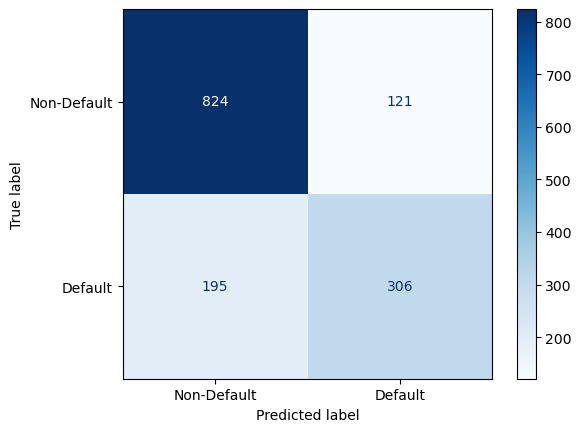

In [112]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test_d, rfc.predict(X_test_d))
display_labels = ['Non-Default', 'Default'] 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues');

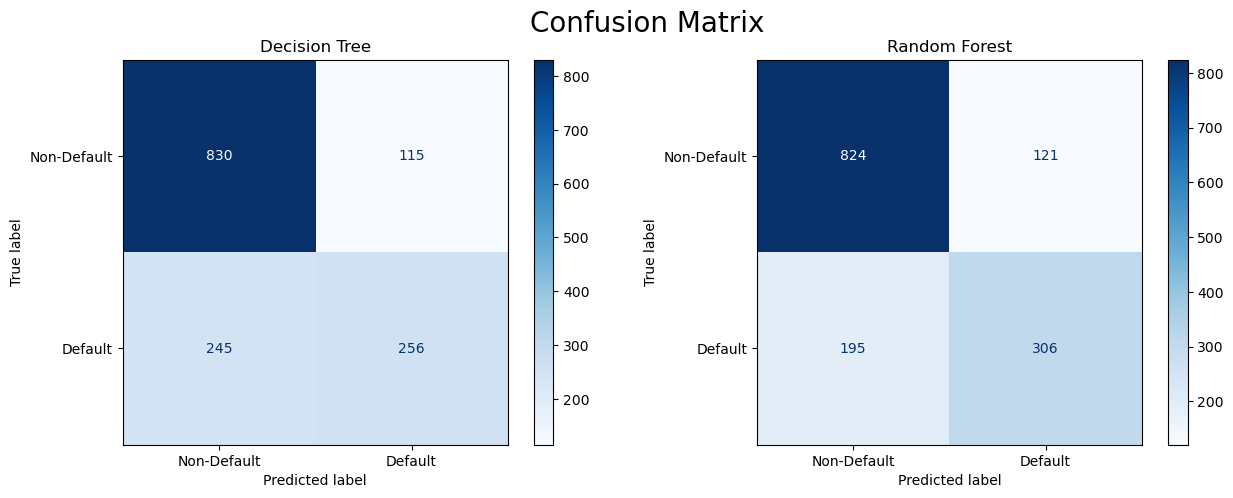

In [113]:
# print the two confusion matrix in parallel
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Confusion Matrix', fontsize=20)
axes[0].set_title('Decision Tree')
axes[1].set_title('Random Forest')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_d, best_dtc.predict(X_test_d)), 
                       display_labels=display_labels).plot(cmap='Blues', ax=axes[0]);
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_d, rfc.predict(X_test_d)),
                          display_labels=display_labels).plot(cmap='Blues', ax=axes[1]);

----
#### Logistic Regression 

In [114]:
# run a logistic regression
logit = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logit.fit(X_train_d, y_train_d)
y_hat_logit = logit.predict(X_test_d)

# print train accuracy
print(f'Train Accuracy: {accuracy_score(y_train_d, logit.predict(X_train_d))}')
# Test accuracy
print(f'Test Accuracy: {accuracy_score(y_test_d, y_hat_logit)}')

Train Accuracy: 0.7577823895641862
Test Accuracy: 0.7323651452282157
